In [1]:
import pytimber as pt
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

import pandas as pd
import numpy as np
import scipy.optimize as opt
import scipy.optimize as opt
from scipy.special import erf
from scipy.stats import norm
from scipy.optimize import curve_fit

from matplotlib.ticker import FixedLocator
import matplotlib
import re 

import h5py


# Define the 2D Gaussian function
def gaussian_2d(X, A, x0, y0, sigma_x, sigma_y):
    x, y = X  # X is a tuple (x, y)
    return (A * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))).ravel()
# Define 1D Gaussian function
def gaussian_1d(y, A, y0, sigma_y):
    return A * np.exp(-((y - y0) ** 2) / (2 * sigma_y ** 2))

#is_swan = False
#if is_swan == False:
#    from nxcals.spark_session_builder import get_or_create
#    from nxcals.api.extraction.data.builders import DataQuery
#    spark = get_or_create("My_APP")

In [ ]:
""" sparkprops={
        "spark.driver.cores", "4",
        "spark.executor.memory", "10g",
        #"spark.sql.parquet.columnarReaderBatchSize", "32",
        "spark.driver.maxResultSize", "1t",
        "spark.task.maxDirectResultSize", "1t"}"""

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("BigMemoryApp")
    .config("spark.driver.memory", "8g")  # set before session creation
    .config("spark.executor.memory", "6g")
    .config("spark.executor.instances", "4")
    .getOrCreate()
)

25/07/04 10:50:57 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3082c8d0{/SQL,null,AVAILABLE,@Spark}
25/07/04 10:50:57 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3f51ea5f{/SQL/json,null,AVAILABLE,@Spark}
25/07/04 10:50:57 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@7d08c984{/SQL/execution,null,AVAILABLE,@Spark}
25/07/04 10:50:57 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@549574f1{/SQL/execution/json,null,AVAILABLE,@Spark}
25/07/04 10:50:57 INFO ContextHandler: Started o.s.j.s.ServletContextHandler@3616385a{/static/sql,null,AVAILABLE,@Spark}
25/07/04 10:50:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [3]:
print(spark.conf.get("spark.sql.parquet.columnarReaderBatchSize"))
spark.conf.set("spark.sql.parquet.columnarReaderBatchSize", "4")
print(spark.conf.get("spark.sql.parquet.columnarReaderBatchSize"))

4096
4


In [4]:
print(spark.conf.get("spark.driver.memory"))
#spark.conf.set("spark.driver.memory", "8g")
#print(spark.conf.get("spark.driver.memory"))

8g


In [5]:
print(spark.conf.get("spark.executor.memory"))

6g


In [6]:
print(spark.conf.get("spark.sql.parquet.enableNestedColumnVectorizedReader"))
spark.conf.set("spark.sql.parquet.enableNestedColumnVectorizedReader", "false")
print(spark.conf.get("spark.sql.parquet.enableNestedColumnVectorizedReader"))

true
false


In [7]:
for key, value in spark.sparkContext.getConf().getAll():
    print(f"{key} = {value}")

spark.blockManager.port = 5101
spark.driver.host = swan-prod-gpu-t4-5x-7z4a6ezrlmh7-node-12
spark.dynamicAllocation.minExecutors = 1
spark.eventLog.enabled = true
spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS = ithdp1001.cern.ch,ithdp1005.cern.ch
spark.driver.port = 32222
spark.dynamicAllocation.maxExecutors = 10
spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES = https://ithdp1001.cern.ch:8088/proxy/application_1740382629255_486974,https://ithdp1005.cern.ch:8088/proxy/application_1740382629255_486974
spark.app.startTime = 1751618939634
spark.eventLog.dir = hdfs://nxcals//var/log/spark-history
spark.extraListeners = sparkmonitor.listener.JupyterSparkMonitorListener
spark.executorEnv.LD_LIBRARY_PATH = /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-19b8a/x86_64-el9-gcc13-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3p2-17f14/x86_64-el9-gcc13-opt/lib/Herwig:/cvmfs/sft.cern.ch/l

In [50]:
spark.sparkContext.getConf().getAll()

[('spark.blockManager.port', '5101'),
 ('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_HOSTS',
  'ithdp1001.cern.ch,ithdp1005.cern.ch'),
 ('spark.dynamicAllocation.maxExecutors', '10'),
 ('spark.driver.appUIAddress',
  'http://swan-prod-gpu-a100--igorl6x22xrf-node-1:31116'),
 ('spark.eventLog.dir', 'hdfs://nxcals//var/log/spark-history'),
 ('spark.extraListeners', 'sparkmonitor.listener.JupyterSparkMonitorListener'),
 ('spark.app.submitTime', '1750758994192'),
 ('spark.executorEnv.LD_LIBRARY_PATH',
  '/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-19b8a/x86_64-el9-gcc13-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3p2-17f14/x86_64-el9-gcc13-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9

In [7]:
def datestring_to_timestamp_utc(date_string):
    # Parse the date string into a datetime object
    date_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S') - timedelta(hours=2)
    
    # Convert the datetime object to UTC timezone if it's not already in UTC
    if date_obj.tzinfo is None or date_obj.tzinfo.utcoffset(date_obj) is None:
        date_obj = date_obj.replace(tzinfo=timezone.utc)
    else:
        date_obj = date_obj.astimezone(timezone.utc)
    
    # Extract the timestamp in seconds
    timestamp_utc = date_obj.timestamp()
    
    return timestamp_utc


def utc_timestamp_to_date_string(timestamp):
    # Convert the timestamp to a datetime object in UTC
    utc_datetime = datetime.fromtimestamp(timestamp, tz=timezone.utc)
    
    # Format the datetime object to a string
    date_string = utc_datetime.strftime('%Y-%m-%d %H:%M:%S')
    
    return date_string


def get_pentagonal(y_lim = 0.003):
    angles = [180-135, 90, 90, 90,135] 
    side_lengths = [31.1e-3, 10e-3, 32e-3, 32e-3, 10e-3]  
    angles = np.radians(angles)

    ALFA_x = [0]
    ALFA_y = [0]
    for i in range(len(side_lengths)):
        angle_sum = np.sum(angles[:i])
        ALFA_x.append(ALFA_x[-1] + side_lengths[i] * np.cos(angle_sum))
        ALFA_y.append(ALFA_y[-1] + side_lengths[i] * np.sin(angle_sum))
    ALFA_x.append(ALFA_x[0])
    ALFA_y.append(ALFA_y[0])

    ALFA_x = [i -side_lengths[0]/2 for i in ALFA_x]
    ALFA_y = [i + y_lim for i in ALFA_y]

    return np.array(ALFA_x), np.array(ALFA_y)

In [8]:
def plot_Tracks(matrix, comulative = False, y_lower=None, y_upper=None, absolute_y_pos= 0, plot_fit = False, use_log_scale = False,
                z_max_2D = None, z_max_y = None, z_max_x = None,  normalize = False, print_info = False, xlim = (-23.0, 23.0), ylim = (0.0, 35.0)):
    
    values = matrix.T
    edges_x = np.linspace(xlim[0], xlim[1], values.shape[1]+1)
    edges_y = np.linspace(ylim[0], ylim[1], values.shape[0]+1)
    
    
    if values is None:
        return
    
    edges_y = edges_y + absolute_y_pos
    fig, ax = plt.subplots(2, 2, figsize=(18, 12))
    masked_values = np.ma.masked_where(values == 0, values)  
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color="white")  
    
    if use_log_scale:
        norm =  matplotlib.colors.LogNorm(vmin=1, vmax=z_max_2D)  # vmin must be > 0
    else:
        norm = None

    pcm = ax[0][0].pcolormesh(edges_x, edges_y, masked_values.T, shading="auto", cmap=cmap, norm=norm, vmax=None if use_log_scale else z_max_2D)

    ALFA_x, ALFA_y = get_pentagonal(absolute_y_pos*1e-3+0.003)
    ax[0][0].plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
    cbar = plt.colorbar(pcm, ax=ax[0][0])  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label("Counts", fontsize=14)  
    ax[0][0].set_xlabel("x [mm]", fontsize=14)
    ax[0][0].set_ylabel("y [mm]", fontsize=14)
    ax[0][0].tick_params(axis='both', which='major', labelsize=12)
    ax[0][0].grid(linestyle=":")
    max_value = np.max(masked_values)
    bin_width_x = np.diff(edges_x)[0]  # Assuming uniform bin widths
    bin_width_y = np.diff(edges_y)[0]  # Assuming uniform bin widths

    #if isinstance(time, list):
    #    hour, minute = time[0][0], time[0][1]
    #    last_hour, last_minute = time[1][0], time[1][1]
    #else:
    #    hour, minute = time[0], time[1]
    #    last_minute = minute  #+ 1 if minute < 59 else 0
    #    last_hour = hour # + 1 if minute == 59 else hour f"{h:02d}:{m:02d}"
    #if comulative:
    #    hour = 13
    #    minute = 17
    #ax[0][0].text(0.65, 0.95,  f"N tracks {values.sum()}\nTime {hour:02d}:{minute:02d} - {last_hour:02d}:{last_minute:02d}", ha="left", va="top", transform=ax[0][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

    #values_with_overflow = np.pad(values, ((1, 1), (0, 0)), mode='constant', constant_values=0)  # Padding for underflow and overflow
    y_projection = np.sum(values, axis=0) 
    bin_centers_y = (edges_y[:-1] + edges_y[1:]) / 2
    ax[0][1].bar(edges_y[:-1], y_projection, width=np.diff(edges_y), align="edge", alpha=0.6)
    ax[0][1].set_xlabel("y [mm]", fontsize=14)
    ax[0][1].set_ylabel("Counts", fontsize=14)
    ax[0][1].tick_params(axis='both', which='major', labelsize=12)
    if z_max_y is not None:
        ax[0][1].set_ylim(0, z_max_y)

    x_projection = np.sum(values, axis=1)  # sum over y → projection along x
    bin_centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])  # Compute bin centers
    ax[1][0].bar(edges_x[:-1], x_projection, width=np.diff(edges_x), align="edge", alpha=0.6)
    ax[1][0].set_xlabel("x [mm]", fontsize=14)
    ax[1][0].set_ylabel("Counts", fontsize=14)
    ax[1][0].tick_params(axis='both', which='major', labelsize=12)
    if z_max_x is not None:
        ax[1][0].set_ylim(0, z_max_x)

    if print_info:
        print("Maximum value in the bins:", max_value)
        print("Bin width along y-axis:", bin_width_y)
        print("Bin width along x-axis:", bin_width_x)
        print("Maximum in x projection:", np.max(x_projection))
        print("Maximum in y projection:", np.max(y_projection))


    cumulative_y_projection = np.cumsum(np.array(y_projection)[::-1])[::-1]
    if normalize:
        cumulative_y_projection = cumulative_y_projection / np.max(cumulative_y_projection)
    ax[1][1].plot(edges_y[:-1], cumulative_y_projection, linewidth=2, label="Cumulative Y Projection")
    ax[1][1].tick_params(axis='both', which='major', labelsize=12)

    if y_lower is not None and y_upper is not None:

        # Filter in y
        y_mask = (bin_centers_y >= y_lower) & (bin_centers_y <= y_upper)
        values_filtered = values[:, y_mask] 
        edges_y_filtered = edges_y[np.r_[np.where(y_mask)[0], np.where(y_mask)[0][-1] + 1]]
        y_centers_filt = 0.5 * (edges_y_filtered[:-1] + edges_y_filtered[1:])
        y_projection_filt = np.sum(values_filtered, axis=0)  # Sum over x-axis
        x_projection_filt = np.sum(values_filtered, axis=1)  # Sum over y-axis
        ax[0][0].axhline(y_lower, color="red", linestyle="--", label="Lower limit")
        ax[0][0].axhline(y_upper, color="red", linestyle="--", label="Upper limit")

        # Create a 2D meshgrid
        X, Y = np.meshgrid(bin_centers_x, y_centers_filt, indexing="ij")  # Ensure correct shape
        # Flatten data for fitting
        xdata = np.vstack((X.ravel(), Y.ravel()))  
        zdata = values_filtered.ravel()  # Use filtered values
        nonzero_mask = zdata > 0
        xdata = xdata[:, nonzero_mask]
        zdata = zdata[nonzero_mask]
        # Fit the 2D Gaussian function
        initial_guess = (np.max(zdata), np.mean(x_projection_filt), np.mean(y_projection_filt), np.std(x_projection_filt), np.std(x_projection_filt))
        popt, pcov = curve_fit(gaussian_2d, xdata, zdata, p0=initial_guess)
        A_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit = popt
        print(f"2D Gauss Fit Parameters:\n A={A_fit}, x0={x0_fit}, y0={y0_fit}, sigma_x={sigma_x_fit}, sigma_y={sigma_y_fit}")
        #ax[0][0].plot(x0_fit, y0_fit, "ro", markersize=10, label="Fit center")

        # Compute Y Projection 
        y_fit = np.linspace(np.min(y_centers_filt), np.max(y_centers_filt), 100)
        gaussian_curve_y = gaussian_1d(y_fit, 1, y0_fit, sigma_y_fit)  #
        # Compute normalization factor: Match the total area of histogram and Gaussian
        hist_integral_y = np.sum(y_projection_filt * np.diff(edges_y_filtered))  # Approximate integral of histogram
        gaussian_integral_y = np.trapz(gaussian_curve_y, y_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_y = hist_integral_y / gaussian_integral_y  # Rescale amplitude properly
        # Recalculate the Gaussian with the correct amplitude
        gaussian_curve_y = gaussian_1d(y_fit, A_rescaled_y, y0_fit, sigma_y_fit)
        ax[0][1].plot(y_fit, gaussian_curve_y, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        ax[0][1].axvline(y_upper)
        ax[0][1].axvline(y_lower)
        legend_text = f"Fit mean: {y0_fit:.2f} mm\nFit sigma: {sigma_y_fit:.2f} mm"
        ax[0][1].text(0.75, 0.95, legend_text, ha="right", va="top", transform=ax[0][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        # Compute X fit 
        x_fit = np.linspace(np.min(bin_centers_x), np.max(bin_centers_x), 100)
        gaussian_curve_x = gaussian_1d(x_fit, 1, x0_fit, sigma_x_fit)  #
        hist_integral_x = np.sum(x_projection_filt * np.diff(edges_x))
        gaussian_integral_x = np.trapz(gaussian_curve_x, x_fit)  # Integral of Gaussian using trapezoidal rule
        A_rescaled_x = hist_integral_x / gaussian_integral_x  # Rescale amplitude properly
        gaussian_curve_x = gaussian_1d(x_fit, A_rescaled_x, x0_fit, sigma_x_fit)
        ax[1][0].plot(x_fit, gaussian_curve_x, color="red", linestyle="--", linewidth=2, label="1D Gaussian Fit")
        legend_text = f"Fit mean: {x0_fit:.2f} mm\nFit sigma: {sigma_x_fit:.2f} mm"
        ax[1][0].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][0].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))

        ax[1][1].axvline(y_lower, color="red", linestyle="--", label="Mean")
        cum_to_fit_erf = cumulative_y_projection[edges_y[:-1] >= y_lower]
        y_to_fit_erf = edges_y[:-1][edges_y[:-1] >= y_lower]
        def erfunc(x,a,b,c,d):
            return a+(b/2.0)*erf((x-c)/(d*np.sqrt(2.0)))
        
        param0 = [np.max(cum_to_fit_erf), np.min(cum_to_fit_erf), np.mean(y_to_fit_erf), np.std(y_to_fit_erf)]
        params, extras = opt.curve_fit(erfunc, y_to_fit_erf, cum_to_fit_erf,  p0=param0)
        print("ERF Fit parameters:", params)
        ax[1][1].plot(edges_y[:-1], erfunc(edges_y[:-1], *params), linewidth=2, label="ERF Fit")
        legend_text = f"Fit mean: {params[2]:.2f} mm\nFit sigma: {params[3]:.2f} mm"
        ax[1][1].text(0.85, 0.95, legend_text, ha="right", va="top", transform=ax[1][1].transAxes, fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle="round,pad=0.5"))
        
        if plot_fit:
            ax[0][0].plot(popt[1], popt[2], 'ro', markersize=2, label='Gaussian Fit Center')
            ellipse = matplotlib.patches.Ellipse((popt[1], popt[2]), width=6*popt[3], height=6*popt[4],
                                                    edgecolor='g', facecolor='none', linewidth=2, zorder=4)
            ax[0][0].add_patch(ellipse)

In [9]:
lbd = pt.LoggingDB(source='nxcals', spark_session=spark)


In [12]:
"""lbd = pt.LoggingDB(source = 'nxcals', spark_session = spark, sparkconf="large",
    sparkprops={
        "spark.driver.cores", "4",
        "spark.executor.memory", "10g",
        #"spark.sql.parquet.columnarReaderBatchSize", "32",
        "spark.driver.maxResultSize", "1t",
        "spark.task.maxDirectResultSize", "1t"
})"""

In [12]:
#ti = '2025-05-13 22:57:40'
#tf = '2025-05-13 22:58:40'

#ti = '2025-06-22 01:35:20'
#tf = '2025-06-22 01:39:00'

ti = '2025-06-22 17:46:20'
tf = '2025-06-22 17:48:00' #'2025-06-22 17:55:22' #


#ti = '2025-06-22 17:54:20'
#tf = '2025-06-22 17:55:22' #


#var = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
var = "hitMapTFT"

In [13]:
fromTimber = lbd.get(var, ti, tf)

In [88]:
fromTimber = lbd.get(var, ti, tf)

25/06/24 11:34:34 ERROR YarnScheduler: Lost executor 1 on ithdp-nxcals6010.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000002 on host: ithdp-nxcals6010.cern.ch. Exit status: 50. Diagnostics: [2025-06-24 11:34:33.833]Exception from container-launch.
Container id: container_e93_1740382629255_280585_01_000002
Exit code: 50
Exception message: Launch container failed
Shell error output: Nonzero exit code=50, error message='Invalid read-only mount'

Shell output: main : command provided 1
main : run as user is cmaccani
main : requested yarn user is cmaccani
Getting exit code file...
Creating script paths...
Writing pid file...
Writing to tmp file /local2/yarn/local/nmPrivate/application_1740382629255_280585/container_e93_1740382629255_280585_01_000002/container_e93_1740382629255_280585_01_000002.pid.tmp
Writing to cgroup task files...
Creating local dirs...
Launching container...


[2025-06-24 11:34:33.854]Container exited with a non-zero exit code 50. Error fil

25/06/24 11:36:20 ERROR YarnScheduler: Lost executor 2 on ithdp-nxcals5003.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000003 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:36:20.067]Container killed on request. Exit code is 143
[2025-06-24 11:36:20.087]Container exited with a non-zero exit code 143. 
[2025-06-24 11:36:20.087]Killed by external signal
.
25/06/24 11:38:03 ERROR YarnScheduler: Lost executor 3 on ithdp-nxcals4013.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000004 on host: ithdp-nxcals4013.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:38:02.798]Container killed on request. Exit code is 143
[2025-06-24 11:38:02.819]Container exited with a non-zero exit code 143. 
[2025-06-24 11:38:02.819]Killed by external signal
.
25/06/24 11:39:52 ERROR YarnScheduler: Lost executor 4 on ithdp-nxcals5003.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000005 on h

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/conversion.py:198: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o211.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorI

Py4JJavaError: An error occurred while calling o211.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 7.0 failed 4 times, most recent failure: Lost task 2.3 in stage 7.0 (TID 35) (ithdp-nxcals5003.cern.ch executor 4): ExecutorLostFailure (executor 4 exited caused by one of the running tasks) Reason: Container from a bad node: container_e93_1740382629255_280585_01_000005 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:39:49.546]Container killed on request. Exit code is 143
[2025-06-24 11:39:49.566]Container exited with a non-zero exit code 143. 
[2025-06-24 11:39:49.566]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:4263)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:4267)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:4242)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:140)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:142)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:137)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:114)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:108)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:69)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:69)


25/06/24 11:34:34 ERROR YarnScheduler: Lost executor 1 on ithdp-nxcals6010.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000002 on host: ithdp-nxcals6010.cern.ch. Exit status: 50. Diagnostics: [2025-06-24 11:34:33.833]Exception from container-launch.
Container id: container_e93_1740382629255_280585_01_000002
Exit code: 50
Exception message: Launch container failed
Shell error output: Nonzero exit code=50, error message='Invalid read-only mount'

Shell output: main : command provided 1
main : run as user is cmaccani
main : requested yarn user is cmaccani
Getting exit code file...
Creating script paths...
Writing pid file...
Writing to tmp file /local2/yarn/local/nmPrivate/application_1740382629255_280585/container_e93_1740382629255_280585_01_000002/container_e93_1740382629255_280585_01_000002.pid.tmp
Writing to cgroup task files...
Creating local dirs...
Launching container...


[2025-06-24 11:34:33.854]Container exited with a non-zero exit code 50. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
5.3]
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623) [spark-core_2.12-3.5.3.jar:3.5.3]
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) [?:?]
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628) [?:?]
	at java.lang.Thread.run(Thread.java:829) [?:?]
Caused by: java.lang.OutOfMemoryError: Direct buffer memory
	at java.nio.Bits.reserveMemory(Bits.java:175) ~[?:?]
	at java.nio.DirectByteBuffer.<init>(DirectByteBuffer.java:118) ~[?:?]
	at java.nio.ByteBuffer.allocateDirect(ByteBuffer.java:317) ~[?:?]
	at io.netty.buffer.UnpooledDirectByteBuf.allocateDirect(UnpooledDirectByteBuf.java:104) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator$InstrumentedUnpooledUnsafeDirectByteBuf.allocateDirect(UnpooledByteBufAllocator.java:215) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledDirectByteBuf.<init>(UnpooledDirectByteBuf.java:64) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledUnsafeDirectByteBuf.<init>(UnpooledUnsafeDirectByteBuf.java:41) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator$InstrumentedUnpooledUnsafeDirectByteBuf.<init>(UnpooledByteBufAllocator.java:210) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator.newDirectBuffer(UnpooledByteBufAllocator.java:91) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.AbstractByteBufAllocator.directBuffer(AbstractByteBufAllocator.java:188) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL$InnerAllocator.newDirectBufferL(PooledByteBufAllocatorL.java:171) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL$InnerAllocator.directBuffer(PooledByteBufAllocatorL.java:214) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL.allocate(PooledByteBufAllocatorL.java:58) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	... 53 more
25/06/24 11:34:31 INFO MemoryStore: MemoryStore cleared
25/06/24 11:34:31 INFO YarnCoarseGrainedExecutorBackend: Got assigned task 24
25/06/24 11:34:31 INFO BlockManager: BlockManager stopped
25/06/24 11:34:31 ERROR Inbox: Ignoring error
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.executor.Executor$TaskRunner@6ee91d7b rejected from java.util.concurrent.ThreadPoolExecutor@314fe303[Shutting down, pool size = 4, active threads = 4, queued tasks = 0, completed tasks = 20]
	at java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2055) ~[?:?]
	at java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:825) ~[?:?]
	at java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1355) ~[?:?]
	at org.apache.spark.executor.Executor.launchTask(Executor.scala:363) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.executor.CoarseGrainedExecutorBackend$$anonfun$receive$1.applyOrElse(CoarseGrainedExecutorBackend.scala:195) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.MessageLoop$$anon$1.run(MessageLoop.scala:41) [spark-core_2.12-3.5.3.jar:3.5.3]
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) [?:?]
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628) [?:?]
	at java.lang.Thread.run(Thread.java:829) [?:?]
25/06/24 11:34:32 INFO ShutdownHookManager: Shutdown hook called


[2025-06-24 11:34:33.855]Container exited with a non-zero exit code 50. Error file: prelaunch.err.
Last 4096 bytes of prelaunch.err :
Last 4096 bytes of stderr :
5.3]
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623) [spark-core_2.12-3.5.3.jar:3.5.3]
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) [?:?]
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628) [?:?]
	at java.lang.Thread.run(Thread.java:829) [?:?]
Caused by: java.lang.OutOfMemoryError: Direct buffer memory
	at java.nio.Bits.reserveMemory(Bits.java:175) ~[?:?]
	at java.nio.DirectByteBuffer.<init>(DirectByteBuffer.java:118) ~[?:?]
	at java.nio.ByteBuffer.allocateDirect(ByteBuffer.java:317) ~[?:?]
	at io.netty.buffer.UnpooledDirectByteBuf.allocateDirect(UnpooledDirectByteBuf.java:104) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator$InstrumentedUnpooledUnsafeDirectByteBuf.allocateDirect(UnpooledByteBufAllocator.java:215) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledDirectByteBuf.<init>(UnpooledDirectByteBuf.java:64) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledUnsafeDirectByteBuf.<init>(UnpooledUnsafeDirectByteBuf.java:41) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator$InstrumentedUnpooledUnsafeDirectByteBuf.<init>(UnpooledByteBufAllocator.java:210) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.UnpooledByteBufAllocator.newDirectBuffer(UnpooledByteBufAllocator.java:91) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.AbstractByteBufAllocator.directBuffer(AbstractByteBufAllocator.java:188) ~[netty-buffer-4.1.96.Final.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL$InnerAllocator.newDirectBufferL(PooledByteBufAllocatorL.java:171) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL$InnerAllocator.directBuffer(PooledByteBufAllocatorL.java:214) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	at io.netty.buffer.PooledByteBufAllocatorL.allocate(PooledByteBufAllocatorL.java:58) ~[arrow-memory-netty-12.0.1.jar:4.1.96.Final]
	... 53 more
25/06/24 11:34:31 INFO MemoryStore: MemoryStore cleared
25/06/24 11:34:31 INFO YarnCoarseGrainedExecutorBackend: Got assigned task 24
25/06/24 11:34:31 INFO BlockManager: BlockManager stopped
25/06/24 11:34:31 ERROR Inbox: Ignoring error
java.util.concurrent.RejectedExecutionException: Task org.apache.spark.executor.Executor$TaskRunner@6ee91d7b rejected from java.util.concurrent.ThreadPoolExecutor@314fe303[Shutting down, pool size = 4, active threads = 4, queued tasks = 0, completed tasks = 20]
	at java.util.concurrent.ThreadPoolExecutor$AbortPolicy.rejectedExecution(ThreadPoolExecutor.java:2055) ~[?:?]
	at java.util.concurrent.ThreadPoolExecutor.reject(ThreadPoolExecutor.java:825) ~[?:?]
	at java.util.concurrent.ThreadPoolExecutor.execute(ThreadPoolExecutor.java:1355) ~[?:?]
	at org.apache.spark.executor.Executor.launchTask(Executor.scala:363) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.executor.CoarseGrainedExecutorBackend$$anonfun$receive$1.applyOrElse(CoarseGrainedExecutorBackend.scala:195) ~[spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.$anonfun$process$1(Inbox.scala:115) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.safelyCall(Inbox.scala:213) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.Inbox.process(Inbox.scala:100) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.MessageLoop.org$apache$spark$rpc$netty$MessageLoop$$receiveLoop(MessageLoop.scala:75) [spark-core_2.12-3.5.3.jar:3.5.3]
	at org.apache.spark.rpc.netty.MessageLoop$$anon$1.run(MessageLoop.scala:41) [spark-core_2.12-3.5.3.jar:3.5.3]
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128) [?:?]
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628) [?:?]
	at java.lang.Thread.run(Thread.java:829) [?:?]
25/06/24 11:34:32 INFO ShutdownHookManager: Shutdown hook called


.

25/06/24 11:36:20 ERROR YarnScheduler: Lost executor 2 on ithdp-nxcals5003.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000003 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:36:20.067]Container killed on request. Exit code is 143
[2025-06-24 11:36:20.087]Container exited with a non-zero exit code 143. 
[2025-06-24 11:36:20.087]Killed by external signal
.
25/06/24 11:38:03 ERROR YarnScheduler: Lost executor 3 on ithdp-nxcals4013.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000004 on host: ithdp-nxcals4013.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:38:02.798]Container killed on request. Exit code is 143
[2025-06-24 11:38:02.819]Container exited with a non-zero exit code 143. 
[2025-06-24 11:38:02.819]Killed by external signal
.
25/06/24 11:39:52 ERROR YarnScheduler: Lost executor 4 on ithdp-nxcals5003.cern.ch: Container from a bad node: container_e93_1740382629255_280585_01_000005 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:39:49.546]Container killed on request. Exit code is 143
[2025-06-24 11:39:49.566]Container exited with a non-zero exit code 143. 
[2025-06-24 11:39:49.566]Killed by external signal
.
25/06/24 11:39:52 ERROR TaskSetManager: Task 2 in stage 7.0 failed 4 times; aborting job

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/conversion.py:198: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true, but has reached the error below and can not continue. Note that 'spark.sql.execution.arrow.pyspark.fallback.enabled' does not have an effect on failures in the middle of computation.
  An error occurred while calling o211.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 7.0 failed 4 times, most recent failure: Lost task 2.3 in stage 7.0 (TID 35) (ithdp-nxcals5003.cern.ch executor 4): ExecutorLostFailure (executor 4 exited caused by one of the running tasks) Reason: Container from a bad node: container_e93_1740382629255_280585_01_000005 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:39:49.546]Container killed on request. Exit code is 143
[2025-06-24 11:39:49.566]Container exited with a non-zero exit code 143. 
[2025-06-24 11:39:49.566]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:4263)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:4267)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:4242)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:140)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:142)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:137)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:114)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:108)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:69)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:69)

  warn(msg)

---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
/tmp/ipykernel_477/3341753548.py in <module>
----> 1 fromTimber = lbd.get(var, ti, tf)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/pytimber/utils.py in wrapper(self, *args, **kwargs)
    172         }
    173         self._tracer.info({**header, **msg})
--> 174         return func(self, *args, **kwargs)
    175 
    176     return wrapper

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/pytimber/pytimber.py in get(self, pattern_or_list, t1, t2, fundamentals, unixtime, fundamental)
    560             fundamentals = Fundamentals(fundamental)
    561 
--> 562         return self.data_converter.convert_from_get(
    563             dataset_dict=self._data_manager._get_as_dataset(
    564                 pattern_or_list, t1, t2, fundamentals

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/pytimber/data.py in convert_from_get(self, dataset_dict, unix_time)
    174         for variables in dataset_dict:
    175             ret = (
--> 176                 self._process_dataset(
    177                     variables, dataset_dict[variables].sort(TIMESTAMP), unix_time
    178                 )

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/pytimber/data.py in _process_dataset(self, variables, ds, unix_time)
    283             vds = ds.select(TIMESTAMP, VALUE, "nxcals_variable_name")
    284 
--> 285         pandas_df = vds.toPandas()
    286         variable_names_series = pandas_df[VARIABLE_NAME]
    287 

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/conversion.py in toPandas(self)
    129 
    130                     self_destruct = jconf.arrowPySparkSelfDestructEnabled()
--> 131                     batches = self._collect_as_arrow(split_batches=self_destruct)
    132                     if len(batches) > 0:
    133                         table = pyarrow.Table.from_batches(batches)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/sql/pandas/conversion.py in _collect_as_arrow(self, split_batches)
    282             with unwrap_spark_exception():
    283                 # Join serving thread and raise any exceptions from collectAsArrowToPython
--> 284                 jsocket_auth_server.getResult()
    285 
    286         # Separate RecordBatches from batch order indices in results

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/py4j/java_gateway.py in __call__(self, *args)
   1320 
   1321         answer = self.gateway_client.send_command(command)
-> 1322         return_value = get_return_value(
   1323             answer, self.gateway_client, self.target_id, self.name)
   1324 

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/python/pyspark/errors/exceptions/captured.py in deco(*a, **kw)
    177     def deco(*a: Any, **kw: Any) -> Any:
    178         try:
--> 179             return f(*a, **kw)
    180         except Py4JJavaError as e:
    181             converted = convert_exception(e.java_exception)

/cvmfs/sft.cern.ch/lcg/views/LCG_106a_nxcals_pro/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/py4j/protocol.py in get_return_value(answer, gateway_client, target_id, name)
    324             value = OUTPUT_CONVERTER[type](answer[2:], gateway_client)
    325             if answer[1] == REFERENCE_TYPE:
--> 326                 raise Py4JJavaError(
    327                     "An error occurred while calling {0}{1}{2}.\n".
    328                     format(target_id, ".", name), value)

Py4JJavaError: An error occurred while calling o211.getResult.
: org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:98)
	at org.apache.spark.security.SocketAuthServer.getResult(SocketAuthServer.scala:94)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 7.0 failed 4 times, most recent failure: Lost task 2.3 in stage 7.0 (TID 35) (ithdp-nxcals5003.cern.ch executor 4): ExecutorLostFailure (executor 4 exited caused by one of the running tasks) Reason: Container from a bad node: container_e93_1740382629255_280585_01_000005 on host: ithdp-nxcals5003.cern.ch. Exit status: 143. Diagnostics: [2025-06-24 11:39:49.546]Container killed on request. Exit code is 143
[2025-06-24 11:39:49.566]Container exited with a non-zero exit code 143. 
[2025-06-24 11:39:49.566]Killed by external signal
.
Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2488)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$5(Dataset.scala:4263)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2(Dataset.scala:4267)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$2$adapted(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1(Dataset.scala:4243)
	at org.apache.spark.sql.Dataset.$anonfun$collectAsArrowToPython$1$adapted(Dataset.scala:4242)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$2(SocketAuthServer.scala:140)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1(SocketAuthServer.scala:142)
	at org.apache.spark.security.SocketAuthServer$.$anonfun$serveToStream$1$adapted(SocketAuthServer.scala:137)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:114)
	at org.apache.spark.security.SocketFuncServer.handleConnection(SocketAuthServer.scala:108)
	at org.apache.spark.security.SocketAuthServer$$anon$1.$anonfun$run$4(SocketAuthServer.scala:69)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:69)




In [17]:
utc_timestamp_to_date_string(fromTimber['hitMapTFT'][0][0])

'2025-06-22 15:46:25'

In [18]:
utc_timestamp_to_date_string(fromTimber['hitMapTFT'][0][-1])

'2025-06-22 15:47:59'

In [19]:
summed_array = np.sum(fromTimber['hitMapTFT'][1], axis=0)

In [20]:
len(fromTimber['hitMapTFT'][0])

95

In [23]:
#test = big_matrix#fromTimber['hitMapTFT'][1][10]
#test.shape

In [25]:
np.sum(summed_array)

513803

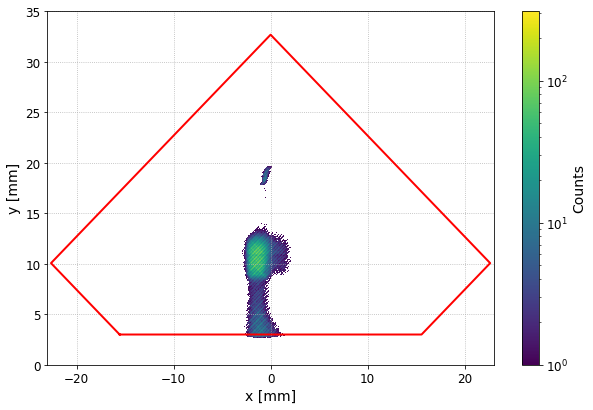

In [26]:
fig, ax = plt.subplots(figsize=(10,6.5))
#fig, ax = plt.subplots(figsize=(2*10,2*6.5))
xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(summed_array, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

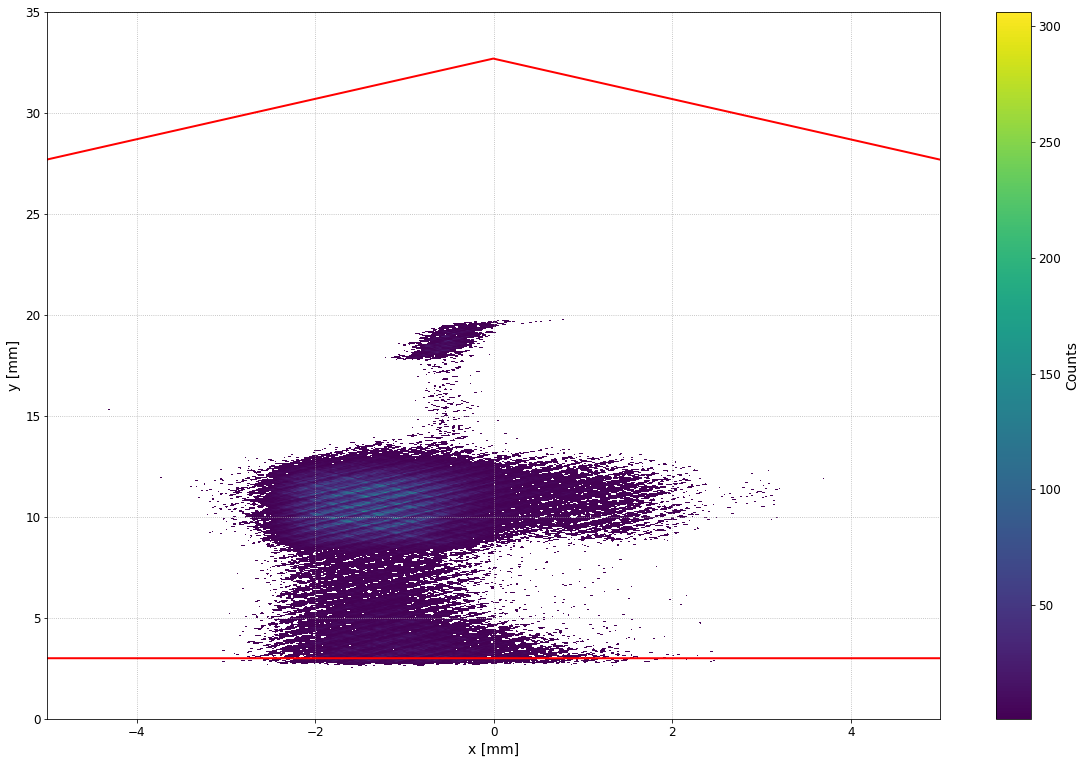

In [27]:
# fig, ax = plt.subplots(figsize=(10,6.5))
fig, ax = plt.subplots(figsize=(2*10,2*6.5))

xlim = (-23.0, 23.0)
ylim = (0.0, 35.0)
ALFA_x, ALFA_y = get_pentagonal()
ax.plot(ALFA_x*1e3, ALFA_y*1e3, color='r', lw=2)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(summed_array, origin='lower', cmap=cmap, vmin=1, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
# ax.set_ylim(17,20)
ax.set_xlim(-5,5)

ax.grid(linestyle=":")

In [28]:
y_projection = np.sum(summed_array.T, axis=0) 
#     values = matrix.T


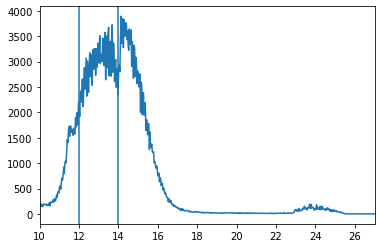

In [29]:
x = 30e-3*np.arange(len(y_projection))
plt.plot(x,y_projection)
plt.axvline(12)
plt.axvline(14)

plt.xlim(10,27)
plt.show()

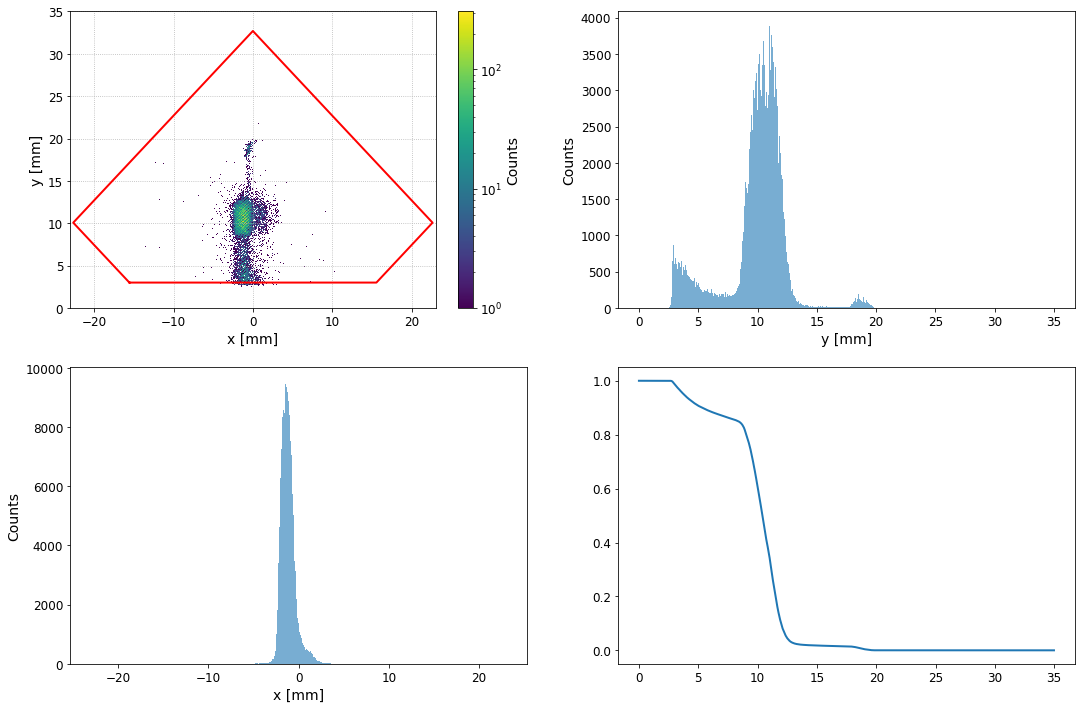

In [32]:
plot_Tracks(summed_array, use_log_scale=True, normalize = True) #, y_lower = 8, y_upper = 11, plot_fit = False, normalize = True)

In [52]:
fromTimber_PIX

{}

In [8]:
import pytimber as pt

lbd = pt.LoggingDB(source='nxcals', spark_session=spark)
#ti = '2025-05-15 18:32:00'
#tf = '2025-05-15 18:33:00'
ti = "2025-06-22 16:47:00"
tf = "2025-06-22 16:49:00"
#var = 'BLMTI.05R7.B2I10_TCPCH.A5R7.B2:LOSS_RS09'
var = "hitMapPix"
fromTimber_PIX = lbd.get(var, ti, tf)

In [9]:
len(fromTimber_PIX["hitMapPix"][0])

480

In [10]:
data_PIX = np.array(fromTimber_PIX["hitMapPix"][1])

In [11]:
data_PIX.shape

(480, 768, 256)

In [12]:
PIX_data_to_plot = np.sum(data_PIX, axis =0)

In [13]:
PIX_data_to_plot.shape

(768, 256)

In [14]:
21.45*2 /14.30

2.9999999999999996

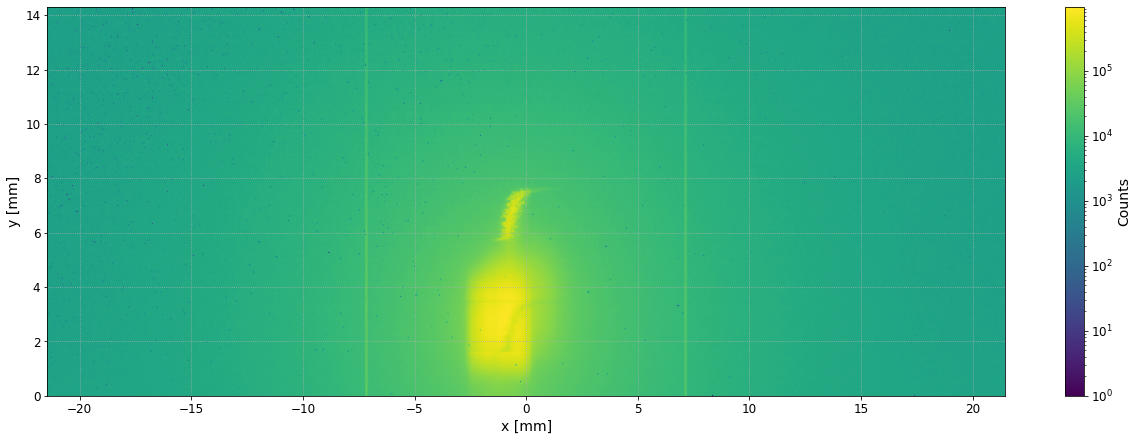

In [15]:
fig, ax = plt.subplots(figsize=(21.45,14.30/2))
xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm()
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

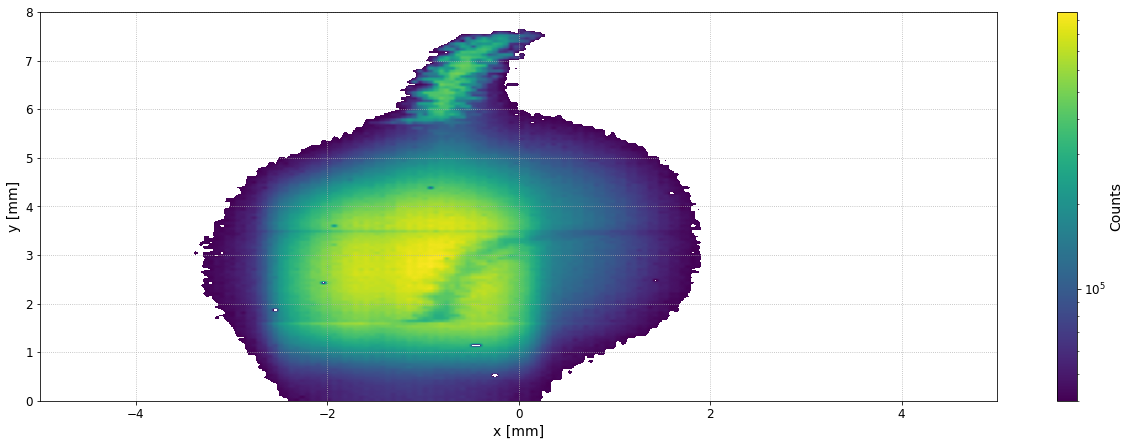

In [16]:
fig, ax = plt.subplots(figsize=(21.45,14.30/2))
xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
norm = matplotlib.colors.LogNorm(vmin=4e4, )
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap, norm = norm,  extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.set_xlim(-5,5)
ax.set_ylim(0,8)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

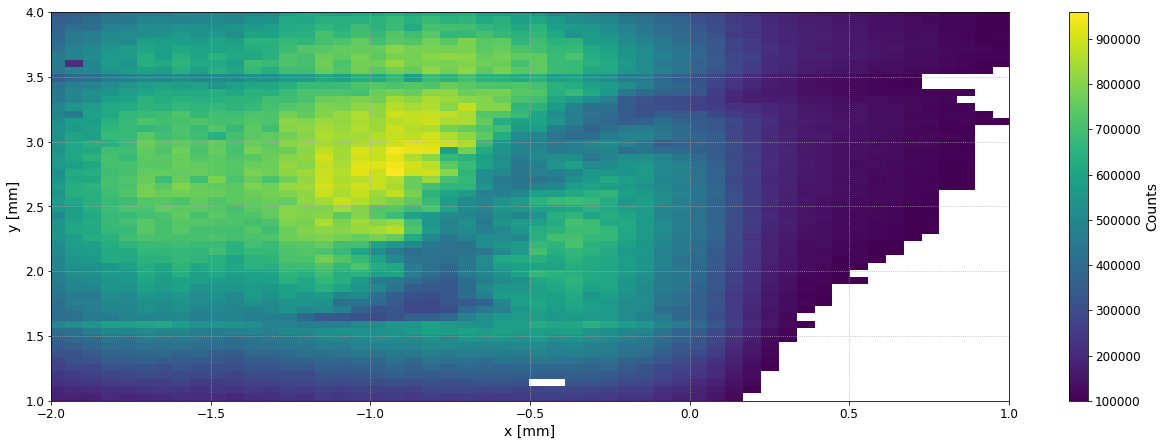

In [17]:
fig, ax = plt.subplots(figsize=(21.45,14.30/2))
xlim = (-21.45, 21.45)
ylim = (0.0, 14.30)
cmap = plt.cm.viridis.copy()  
cmap.set_under('white')
# norm = matplotlib.colors.LogNorm(vmin=4e4, )
plt.imshow(PIX_data_to_plot.T, origin='lower', cmap=cmap,vmin=1e5, extent=[xlim[0], xlim[1], ylim[0], ylim[1]], aspect='auto')  
cbar = plt.colorbar(ax=ax)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(label='Counts', fontsize=14)  
ax.set_xlabel('x [mm]', fontsize=14)
ax.set_ylabel('y [mm]', fontsize=14)
ax.set_xlim(-2,1)
ax.set_ylim(1,4)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(linestyle=":")

In [18]:
PIX_data_to_plot

array([[2526, 3003, 2169, ..., 2572, 2477, 2279],
       [3004, 3388, 2893, ..., 3107, 2016,   48],
       [3220, 3087, 3049, ..., 2201, 2239, 2545],
       ...,
       [2867, 2945, 3041, ..., 2545, 2477, 2549],
       [2739, 2813, 2926, ..., 2419, 2494, 2686],
       [2769, 2827, 2681, ..., 2650, 2409, 2558]])

In [18]:
np.sum(PIX_data_to_plot)

3289815995

In [19]:
PIX_data_to_plot

array([[2526, 3003, 2169, ..., 2572, 2477, 2279],
       [3004, 3388, 2893, ..., 3107, 2016,   48],
       [3220, 3087, 3049, ..., 2201, 2239, 2545],
       ...,
       [2867, 2945, 3041, ..., 2545, 2477, 2549],
       [2739, 2813, 2926, ..., 2419, 2494, 2686],
       [2769, 2827, 2681, ..., 2650, 2409, 2558]])

In [19]:
PIX_data_to_plot.shape

(768, 256)

In [21]:

# Define HDF5 save path
hdf5_path = "./PIX_DC.h5"


# Save to HDF5
with h5py.File(hdf5_path, "w") as f:
    f.create_dataset("PIX_DC", data=PIX_data_to_plot)

# Reload the HDF5 file to verify
with h5py.File(hdf5_path, "r") as f:
    reloaded_hdf_array = f["PIX_DC"][:]

# Check shape and content match
reloaded_hdf_array.shape, np.allclose(PIX_data_to_plot, reloaded_hdf_array)


((768, 256), True)

In [23]:
reloaded_hdf_array == PIX_data_to_plot

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [18]:
file_path = 'runs.txt'

with open(file_path, 'r') as file:
    clean_text = ' '.join(file.read().splitlines()).strip()
    file_names = clean_text.split()
    file_list = list(file_names)


run_numbers = []
timestamps = []


for file_name in file_list:

    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = int(match.group(1))

    parts = file_name.split('-')
    year = int(parts[1])
    month = int(parts[2])
    day = int(parts[3])
    if len(parts) > 6:
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0]
    else:
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"
    
    timestamp = f"{year}-{month}-{day} {hour}:{minute}:{second}"
    run_numbers.append(run_number)
    timestamps.append(timestamp)


df = pd.DataFrame({'Run Number': run_numbers, 'Timestamp': timestamps})

grouped = df.groupby('Run Number')['Timestamp'].agg(['min', 'max'])
grouped = grouped.rename(columns={'min': 'start_time', 'max': 'end_time'})


final_info = grouped.to_dict(orient='index')



In [19]:
final_info[1750607184]

{'start_time': '2025-6-22 17:46:26', 'end_time': '2025-6-22 17:55:22'}

In [31]:

def find_run_number(df, timestamp_str):

    df['start_time'] = pd.to_datetime(df['start_time'])
    df['end_time'] = pd.to_datetime(df['end_time'])

    timestamp = pd.to_datetime(timestamp_str)

    match = df[(df['start_time'] <= timestamp) & (df['end_time'] >= timestamp)]

    if not match.empty:
        return match.index[0] 
    else:
        return None


In [33]:
find_run_number(grouped, '2025-6-22 17:57:00' )

In [34]:
grouped

,start_time,end_time
Run Number,,
1745130431,2025-04-20 10:00:00,2025-04-20 10:00:00
1745138178,2025-04-20 10:00:00,2025-04-20 10:00:00
1745142439,2025-04-20 12:00:00,2025-06-21 07:54:32
1745147836,2025-04-20 13:00:00,2025-04-20 17:00:00
1750484801,2025-06-21 07:56:26,2025-06-21 08:34:46
...,...,...
1750615822,2025-06-22 20:10:24,2025-06-22 20:21:16
1750616771,2025-06-22 20:26:13,2025-06-22 20:51:04
1750618388,2025-06-22 20:53:11,2025-06-22 20:57:50


-rw-r--r-- 1 korcyl zp 1.4M Jun 22 21:16 r1750619367_3-2025-06-22-21-16-28.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:16 r1750619367_3-2025-06-22-21-16-05.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:15 r1750619367_3-2025-06-22-21-15-41.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 21:15 r1750619367_3-2025-06-22-21-15-19.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:14 r1750619367_3-2025-06-22-21-14-54.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:14 r1750619367_3-2025-06-22-21-14-31.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:14 r1750619367_3-2025-06-22-21-14-08.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:13 r1750619367_3-2025-06-22-21-13-44.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:13 r1750619367_3-2025-06-22-21-13-21.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:13 r1750619367_3-2025-06-22-21-12-58.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:12 r1750619367_3-2025-06-22-21-12-35.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:12 r1750619367_3-2025-06-22-21-12-12.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 21:11 r1750619367_3-2025-06-22-21-11-49.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:11 r1750619367_2-2025-06-22-21-11-25.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:11 r1750619367_2-2025-06-22-21-11-01.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:10 r1750619367_2-2025-06-22-21-10-38.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:10 r1750619367_1-2025-06-22-21-10-15.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 21:09 r1750619367_1-2025-06-22-21-09-51.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 21:09 r1750619367_0-2025-06-22-21-09-29.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:08 r1750618732_7-2025-06-22-21-08-36.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:08 r1750618732_7-2025-06-22-21-08-13.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:07 r1750618732_7-2025-06-22-21-07-48.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:07 r1750618732_7-2025-06-22-21-07-26.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:07 r1750618732_7-2025-06-22-21-07-03.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:06 r1750618732_7-2025-06-22-21-06-39.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:06 r1750618732_7-2025-06-22-21-06-16.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:05 r1750618732_7-2025-06-22-21-05-53.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:05 r1750618732_7-2025-06-22-21-05-30.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:05 r1750618732_7-2025-06-22-21-05-07.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:04 r1750618732_7-2025-06-22-21-04-44.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 21:04 r1750618732_7-2025-06-22-21-04-20.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 21:03 r1750618732_6-2025-06-22-21-03-56.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 21:03 r1750618732_6-2025-06-22-21-03-34.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 21:03 r1750618732_5-2025-06-22-21-03-10.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 21:02 r1750618732_4-2025-06-22-21-02-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 21:02 r1750618732_4-2025-06-22-21-02-24.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 21:02 r1750618732_4-2025-06-22-21-02-01.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 21:01 r1750618732_3-2025-06-22-21-01-37.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:01 r1750618732_3-2025-06-22-21-01-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:00 r1750618732_2-2025-06-22-21-00-50.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 21:00 r1750618732_2-2025-06-22-21-00-27.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 21:00 r1750618732_2-2025-06-22-21-00-04.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:59 r1750618732_1-2025-06-22-20-59-40.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:59 r1750618732_1-2025-06-22-20-59-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:58 r1750618732_0-2025-06-22-20-58-54.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:57 r1750618388_1-2025-06-22-20-57-50.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:57 r1750618388_1-2025-06-22-20-57-27.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:57 r1750618388_1-2025-06-22-20-57-04.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:56 r1750618388_1-2025-06-22-20-56-41.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:56 r1750618388_1-2025-06-22-20-56-17.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:55 r1750618388_1-2025-06-22-20-55-54.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:55 r1750618388_1-2025-06-22-20-55-31.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:55 r1750618388_1-2025-06-22-20-55-07.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:54 r1750618388_1-2025-06-22-20-54-44.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:54 r1750618388_1-2025-06-22-20-54-21.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:54 r1750618388_1-2025-06-22-20-53-57.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:53 r1750618388_1-2025-06-22-20-53-34.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:53 r1750618388_0-2025-06-22-20-53-11.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:51 r1750616771_22-2025-06-22-20-51-04.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:50 r1750616771_22-2025-06-22-20-50-41.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 20:50 r1750616771_22-2025-06-22-20-50-18.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 20:49 r1750616771_22-2025-06-22-20-49-55.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:49 r1750616771_22-2025-06-22-20-49-32.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:49 r1750616771_22-2025-06-22-20-49-09.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:48 r1750616771_22-2025-06-22-20-48-45.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:48 r1750616771_22-2025-06-22-20-48-22.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 20:48 r1750616771_22-2025-06-22-20-47-58.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:47 r1750616771_22-2025-06-22-20-47-35.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:47 r1750616771_22-2025-06-22-20-47-12.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 20:46 r1750616771_21-2025-06-22-20-46-48.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:46 r1750616771_21-2025-06-22-20-46-25.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 20:46 r1750616771_21-2025-06-22-20-46-02.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:45 r1750616771_20-2025-06-22-20-45-39.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:45 r1750616771_20-2025-06-22-20-45-15.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:44 r1750616771_19-2025-06-22-20-44-52.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 20:44 r1750616771_19-2025-06-22-20-44-27.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 20:44 r1750616771_19-2025-06-22-20-44-04.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:43 r1750616771_18-2025-06-22-20-43-41.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:43 r1750616771_17-2025-06-22-20-43-18.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 20:42 r1750616771_17-2025-06-22-20-42-54.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:42 r1750616771_17-2025-06-22-20-42-32.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:42 r1750616771_16-2025-06-22-20-42-08.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:41 r1750616771_16-2025-06-22-20-41-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:41 r1750616771_16-2025-06-22-20-41-22.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:41 r1750616771_15-2025-06-22-20-40-58.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:40 r1750616771_15-2025-06-22-20-40-34.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:40 r1750616771_14-2025-06-22-20-40-11.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:39 r1750616771_14-2025-06-22-20-39-48.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:39 r1750616771_14-2025-06-22-20-39-24.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:39 r1750616771_13-2025-06-22-20-39-02.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:38 r1750616771_13-2025-06-22-20-38-38.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:38 r1750616771_12-2025-06-22-20-38-15.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:37 r1750616771_12-2025-06-22-20-37-52.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:37 r1750616771_12-2025-06-22-20-37-27.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:37 r1750616771_11-2025-06-22-20-37-04.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:36 r1750616771_11-2025-06-22-20-36-41.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:36 r1750616771_10-2025-06-22-20-36-17.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:35 r1750616771_10-2025-06-22-20-35-54.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:35 r1750616771_10-2025-06-22-20-35-32.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:35 r1750616771_9-2025-06-22-20-35-08.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:34 r1750616771_9-2025-06-22-20-34-45.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:34 r1750616771_9-2025-06-22-20-34-22.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:34 r1750616771_8-2025-06-22-20-33-57.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:33 r1750616771_8-2025-06-22-20-33-34.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:33 r1750616771_7-2025-06-22-20-33-11.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:32 r1750616771_7-2025-06-22-20-32-48.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:32 r1750616771_7-2025-06-22-20-32-25.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:32 r1750616771_6-2025-06-22-20-32-02.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:31 r1750616771_6-2025-06-22-20-31-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:31 r1750616771_5-2025-06-22-20-31-15.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:30 r1750616771_5-2025-06-22-20-30-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:30 r1750616771_5-2025-06-22-20-30-28.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:30 r1750616771_4-2025-06-22-20-30-04.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:29 r1750616771_4-2025-06-22-20-29-42.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:29 r1750616771_3-2025-06-22-20-29-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:28 r1750616771_3-2025-06-22-20-28-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:28 r1750616771_3-2025-06-22-20-28-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:28 r1750616771_2-2025-06-22-20-28-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:27 r1750616771_2-2025-06-22-20-27-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:27 r1750616771_2-2025-06-22-20-27-22.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:27 r1750616771_1-2025-06-22-20-26-59.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:26 r1750616771_1-2025-06-22-20-26-36.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:26 r1750616771_0-2025-06-22-20-26-13.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:21 r1750615822_9-2025-06-22-20-21-16.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:20 r1750615822_9-2025-06-22-20-20-53.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:20 r1750615822_9-2025-06-22-20-20-30.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:20 r1750615822_9-2025-06-22-20-20-06.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:19 r1750615822_9-2025-06-22-20-19-44.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:19 r1750615822_9-2025-06-22-20-19-20.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:18 r1750615822_9-2025-06-22-20-18-56.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:18 r1750615822_9-2025-06-22-20-18-33.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:18 r1750615822_8-2025-06-22-20-18-09.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:17 r1750615822_8-2025-06-22-20-17-46.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:17 r1750615822_7-2025-06-22-20-17-23.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:17 r1750615822_7-2025-06-22-20-17-00.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:16 r1750615822_7-2025-06-22-20-16-36.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:16 r1750615822_6-2025-06-22-20-16-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:15 r1750615822_6-2025-06-22-20-15-49.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:15 r1750615822_5-2025-06-22-20-15-26.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 20:15 r1750615822_5-2025-06-22-20-15-03.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 20:14 r1750615822_5-2025-06-22-20-14-39.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:14 r1750615822_4-2025-06-22-20-14-16.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:13 r1750615822_4-2025-06-22-20-13-53.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:13 r1750615822_3-2025-06-22-20-13-30.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:13 r1750615822_3-2025-06-22-20-13-07.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:12 r1750615822_3-2025-06-22-20-12-44.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:12 r1750615822_2-2025-06-22-20-12-19.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:11 r1750615822_2-2025-06-22-20-11-56.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:11 r1750615822_2-2025-06-22-20-11-33.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:11 r1750615822_1-2025-06-22-20-11-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:10 r1750615822_1-2025-06-22-20-10-47.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:10 r1750615822_0-2025-06-22-20-10-24.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:08 r1750615308_6-2025-06-22-20-08-51.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:08 r1750615308_6-2025-06-22-20-08-28.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:08 r1750615308_6-2025-06-22-20-08-05.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:07 r1750615308_6-2025-06-22-20-07-42.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:07 r1750615308_6-2025-06-22-20-07-18.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:06 r1750615308_6-2025-06-22-20-06-55.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 20:06 r1750615308_6-2025-06-22-20-06-32.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:06 r1750615308_5-2025-06-22-20-06-08.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:05 r1750615308_5-2025-06-22-20-05-44.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:05 r1750615308_5-2025-06-22-20-05-21.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 20:05 r1750615308_4-2025-06-22-20-04-58.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:04 r1750615308_4-2025-06-22-20-04-35.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:04 r1750615308_4-2025-06-22-20-04-12.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:03 r1750615308_3-2025-06-22-20-03-48.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:03 r1750615308_3-2025-06-22-20-03-24.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 20:03 r1750615308_2-2025-06-22-20-03-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:02 r1750615308_2-2025-06-22-20-02-37.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:02 r1750615308_2-2025-06-22-20-02-14.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 20:01 r1750615308_0-2025-06-22-20-01-51.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:59 r1750614884_3-2025-06-22-19-59-48.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:59 r1750614884_3-2025-06-22-19-59-25.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:59 r1750614884_3-2025-06-22-19-59-02.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 19:58 r1750614884_3-2025-06-22-19-58-38.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:58 r1750614884_3-2025-06-22-19-58-15.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:57 r1750614884_3-2025-06-22-19-57-52.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:57 r1750614884_3-2025-06-22-19-57-29.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:57 r1750614884_3-2025-06-22-19-57-06.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:56 r1750614884_2-2025-06-22-19-56-42.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:56 r1750614884_2-2025-06-22-19-56-19.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:55 r1750614884_2-2025-06-22-19-55-56.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:55 r1750614884_1-2025-06-22-19-55-33.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 19:55 r1750614884_1-2025-06-22-19-55-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:54 r1750614884_0-2025-06-22-19-54-46.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:53 r1750613904_12-2025-06-22-19-53-37.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:53 r1750613904_12-2025-06-22-19-53-13.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:52 r1750613904_12-2025-06-22-19-52-50.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:52 r1750613904_12-2025-06-22-19-52-27.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:52 r1750613904_12-2025-06-22-19-52-04.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:51 r1750613904_12-2025-06-22-19-51-41.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:51 r1750613904_12-2025-06-22-19-51-18.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:50 r1750613904_12-2025-06-22-19-50-55.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:50 r1750613904_12-2025-06-22-19-50-31.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:50 r1750613904_12-2025-06-22-19-50-07.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:49 r1750613904_12-2025-06-22-19-49-44.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 19:49 r1750613904_11-2025-06-22-19-49-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:49 r1750613904_11-2025-06-22-19-48-57.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:48 r1750613904_10-2025-06-22-19-48-34.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:48 r1750613904_10-2025-06-22-19-48-11.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:47 r1750613904_10-2025-06-22-19-47-48.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:47 r1750613904_9-2025-06-22-19-47-24.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:47 r1750613904_9-2025-06-22-19-47-00.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:46 r1750613904_9-2025-06-22-19-46-37.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:46 r1750613904_8-2025-06-22-19-46-14.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:45 r1750613904_8-2025-06-22-19-45-50.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:45 r1750613904_7-2025-06-22-19-45-27.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:45 r1750613904_7-2025-06-22-19-45-04.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:44 r1750613904_7-2025-06-22-19-44-41.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:44 r1750613904_6-2025-06-22-19-44-18.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:43 r1750613904_6-2025-06-22-19-43-53.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:43 r1750613904_5-2025-06-22-19-43-30.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:43 r1750613904_5-2025-06-22-19-43-07.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:42 r1750613904_5-2025-06-22-19-42-43.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:42 r1750613904_4-2025-06-22-19-42-20.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:42 r1750613904_4-2025-06-22-19-41-57.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:41 r1750613904_3-2025-06-22-19-41-34.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:41 r1750613904_3-2025-06-22-19-41-11.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:40 r1750613904_3-2025-06-22-19-40-48.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:40 r1750613904_2-2025-06-22-19-40-24.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:40 r1750613904_2-2025-06-22-19-40-00.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 19:39 r1750613904_2-2025-06-22-19-39-37.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 19:39 r1750613904_1-2025-06-22-19-39-14.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 19:38 r1750613904_1-2025-06-22-19-38-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:38 r1750613904_0-2025-06-22-19-38-27.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:36 r1750613178_8-2025-06-22-19-36-50.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:36 r1750613178_8-2025-06-22-19-36-27.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:36 r1750613178_8-2025-06-22-19-36-03.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:35 r1750613178_8-2025-06-22-19-35-40.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:35 r1750613178_8-2025-06-22-19-35-17.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:34 r1750613178_8-2025-06-22-19-34-53.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:34 r1750613178_8-2025-06-22-19-34-30.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:34 r1750613178_8-2025-06-22-19-34-07.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:33 r1750613178_8-2025-06-22-19-33-43.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:33 r1750613178_7-2025-06-22-19-33-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:33 r1750613178_7-2025-06-22-19-32-57.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:32 r1750613178_7-2025-06-22-19-32-34.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:32 r1750613178_6-2025-06-22-19-32-11.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:31 r1750613178_6-2025-06-22-19-31-47.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:31 r1750613178_5-2025-06-22-19-31-23.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:31 r1750613178_5-2025-06-22-19-31-00.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:30 r1750613178_5-2025-06-22-19-30-37.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:30 r1750613178_4-2025-06-22-19-30-13.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:29 r1750613178_4-2025-06-22-19-29-50.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:29 r1750613178_3-2025-06-22-19-29-27.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 19:29 r1750613178_3-2025-06-22-19-29-04.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:28 r1750613178_3-2025-06-22-19-28-40.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:28 r1750613178_2-2025-06-22-19-28-16.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 19:27 r1750613178_2-2025-06-22-19-27-53.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 19:27 r1750613178_2-2025-06-22-19-27-30.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 19:27 r1750613178_1-2025-06-22-19-27-06.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:26 r1750613178_1-2025-06-22-19-26-43.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:26 r1750613178_0-2025-06-22-19-26-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:24 r1750612580_6-2025-06-22-19-24-32.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:24 r1750612580_6-2025-06-22-19-24-09.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:23 r1750612580_6-2025-06-22-19-23-45.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:23 r1750612580_6-2025-06-22-19-23-22.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:23 r1750612580_6-2025-06-22-19-22-59.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:22 r1750612580_6-2025-06-22-19-22-36.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:22 r1750612580_6-2025-06-22-19-22-13.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:21 r1750612580_6-2025-06-22-19-21-49.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:21 r1750612580_5-2025-06-22-19-21-26.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:21 r1750612580_5-2025-06-22-19-21-02.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:20 r1750612580_5-2025-06-22-19-20-39.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:20 r1750612580_4-2025-06-22-19-20-16.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:19 r1750612580_4-2025-06-22-19-19-52.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:19 r1750612580_3-2025-06-22-19-19-29.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:19 r1750612580_3-2025-06-22-19-19-06.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:18 r1750612580_3-2025-06-22-19-18-43.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:18 r1750612580_2-2025-06-22-19-18-18.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:17 r1750612580_2-2025-06-22-19-17-55.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:17 r1750612580_2-2025-06-22-19-17-32.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:17 r1750612580_1-2025-06-22-19-17-07.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 19:16 r1750612580_1-2025-06-22-19-16-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:16 r1750612580_0-2025-06-22-19-16-22.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:15 r1750611926_7-2025-06-22-19-15-11.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:14 r1750611926_7-2025-06-22-19-14-48.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:14 r1750611926_7-2025-06-22-19-14-24.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:14 r1750611926_7-2025-06-22-19-14-00.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:13 r1750611926_7-2025-06-22-19-13-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:13 r1750611926_7-2025-06-22-19-13-14.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:12 r1750611926_7-2025-06-22-19-12-50.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:12 r1750611926_7-2025-06-22-19-12-27.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 19:12 r1750611926_7-2025-06-22-19-12-04.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:11 r1750611926_7-2025-06-22-19-11-41.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:11 r1750611926_6-2025-06-22-19-11-18.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:10 r1750611926_6-2025-06-22-19-10-54.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 19:10 r1750611926_5-2025-06-22-19-10-30.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:10 r1750611926_5-2025-06-22-19-10-07.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:09 r1750611926_5-2025-06-22-19-09-44.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:09 r1750611926_4-2025-06-22-19-09-20.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:09 r1750611926_4-2025-06-22-19-08-57.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:08 r1750611926_3-2025-06-22-19-08-34.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:08 r1750611926_3-2025-06-22-19-08-11.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:07 r1750611926_3-2025-06-22-19-07-48.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:07 r1750611926_2-2025-06-22-19-07-24.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:07 r1750611926_2-2025-06-22-19-07-00.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:06 r1750611926_2-2025-06-22-19-06-37.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 19:06 r1750611926_1-2025-06-22-19-06-14.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 19:05 r1750611926_1-2025-06-22-19-05-51.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 19:05 r1750611926_0-2025-06-22-19-05-28.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:03 r1750611261_6-2025-06-22-19-03-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:02 r1750611261_6-2025-06-22-19-02-56.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 19:02 r1750611261_6-2025-06-22-19-02-33.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:02 r1750611261_6-2025-06-22-19-02-10.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 19:01 r1750611261_6-2025-06-22-19-01-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:01 r1750611261_6-2025-06-22-19-01-24.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 19:01 r1750611261_6-2025-06-22-19-01-01.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 19:00 r1750611261_6-2025-06-22-19-00-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 19:00 r1750611261_6-2025-06-22-19-00-14.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:59 r1750611261_6-2025-06-22-18-59-50.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:59 r1750611261_5-2025-06-22-18-59-26.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:59 r1750611261_5-2025-06-22-18-59-03.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:58 r1750611261_5-2025-06-22-18-58-40.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:58 r1750611261_4-2025-06-22-18-58-16.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:57 r1750611261_4-2025-06-22-18-57-54.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:57 r1750611261_3-2025-06-22-18-57-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:57 r1750611261_3-2025-06-22-18-57-07.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:56 r1750611261_3-2025-06-22-18-56-44.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:56 r1750611261_2-2025-06-22-18-56-20.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:55 r1750611261_2-2025-06-22-18-55-56.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:55 r1750611261_2-2025-06-22-18-55-33.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:55 r1750611261_1-2025-06-22-18-55-09.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 18:54 r1750611261_1-2025-06-22-18-54-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 18:54 r1750611261_0-2025-06-22-18-54-23.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:53 r1750610787_3-2025-06-22-18-53-06.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:52 r1750610787_3-2025-06-22-18-52-43.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:52 r1750610787_3-2025-06-22-18-52-20.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:52 r1750610787_3-2025-06-22-18-51-55.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:51 r1750610787_3-2025-06-22-18-51-32.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:51 r1750610787_3-2025-06-22-18-51-09.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:50 r1750610787_3-2025-06-22-18-50-46.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:50 r1750610787_3-2025-06-22-18-50-22.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:50 r1750610787_3-2025-06-22-18-49-59.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:49 r1750610787_3-2025-06-22-18-49-36.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:49 r1750610787_3-2025-06-22-18-49-13.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:48 r1750610787_3-2025-06-22-18-48-50.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:48 r1750610787_2-2025-06-22-18-48-26.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:48 r1750610787_2-2025-06-22-18-48-02.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:47 r1750610787_2-2025-06-22-18-47-39.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:47 r1750610787_1-2025-06-22-18-47-15.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 18:46 r1750610787_1-2025-06-22-18-46-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 18:46 r1750610787_0-2025-06-22-18-46-29.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:45 r1750609911_7-2025-06-22-18-45-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:45 r1750609911_7-2025-06-22-18-45-07.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:44 r1750609911_7-2025-06-22-18-44-44.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:44 r1750609911_7-2025-06-22-18-44-19.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:43 r1750609911_7-2025-06-22-18-43-56.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:43 r1750609911_7-2025-06-22-18-43-33.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:43 r1750609911_7-2025-06-22-18-43-10.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:42 r1750609911_7-2025-06-22-18-42-47.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:42 r1750609911_7-2025-06-22-18-42-23.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:42 r1750609911_7-2025-06-22-18-42-00.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:41 r1750609911_7-2025-06-22-18-41-37.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:41 r1750609911_7-2025-06-22-18-41-14.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:40 r1750609911_7-2025-06-22-18-40-49.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:40 r1750609911_7-2025-06-22-18-40-26.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:40 r1750609911_7-2025-06-22-18-40-03.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:39 r1750609911_7-2025-06-22-18-39-40.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:39 r1750609911_7-2025-06-22-18-39-16.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:38 r1750609911_7-2025-06-22-18-38-53.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:38 r1750609911_7-2025-06-22-18-38-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:38 r1750609911_7-2025-06-22-18-38-07.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:37 r1750609911_6-2025-06-22-18-37-44.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:37 r1750609911_6-2025-06-22-18-37-20.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:36 r1750609911_5-2025-06-22-18-36-56.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:36 r1750609911_5-2025-06-22-18-36-33.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:36 r1750609911_5-2025-06-22-18-36-10.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:35 r1750609911_4-2025-06-22-18-35-47.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:35 r1750609911_4-2025-06-22-18-35-24.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:35 r1750609911_3-2025-06-22-18-35-01.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:34 r1750609911_3-2025-06-22-18-34-37.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:34 r1750609911_3-2025-06-22-18-34-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:33 r1750609911_2-2025-06-22-18-33-50.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:33 r1750609911_2-2025-06-22-18-33-26.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:33 r1750609911_2-2025-06-22-18-33-03.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:32 r1750609911_1-2025-06-22-18-32-39.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 18:32 r1750609911_1-2025-06-22-18-32-16.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 18:31 r1750609911_0-2025-06-22-18-31-53.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:30 r1750609459_4-2025-06-22-18-30-12.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:29 r1750609459_4-2025-06-22-18-29-49.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:29 r1750609459_4-2025-06-22-18-29-26.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:29 r1750609459_4-2025-06-22-18-29-03.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:28 r1750609459_4-2025-06-22-18-28-40.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:28 r1750609459_4-2025-06-22-18-28-16.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:27 r1750609459_4-2025-06-22-18-27-53.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:27 r1750609459_4-2025-06-22-18-27-30.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:27 r1750609459_3-2025-06-22-18-27-06.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:26 r1750609459_3-2025-06-22-18-26-42.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:26 r1750609459_2-2025-06-22-18-26-19.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:25 r1750609459_2-2025-06-22-18-25-55.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:25 r1750609459_2-2025-06-22-18-25-32.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:25 r1750609459_1-2025-06-22-18-25-09.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 18:24 r1750609459_1-2025-06-22-18-24-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 18:24 r1750609459_0-2025-06-22-18-24-21.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:22 r1750608772_9-2025-06-22-18-22-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:21 r1750608772_9-2025-06-22-18-21-50.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:21 r1750608772_9-2025-06-22-18-21-27.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:21 r1750608772_9-2025-06-22-18-21-04.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:20 r1750608772_9-2025-06-22-18-20-40.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:20 r1750608772_9-2025-06-22-18-20-17.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:19 r1750608772_9-2025-06-22-18-19-54.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:19 r1750608772_9-2025-06-22-18-19-31.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:19 r1750608772_8-2025-06-22-18-19-07.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:18 r1750608772_8-2025-06-22-18-18-45.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:18 r1750608772_6-2025-06-22-18-18-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:18 r1750608772_6-2025-06-22-18-17-57.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:17 r1750608772_6-2025-06-22-18-17-34.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:17 r1750608772_5-2025-06-22-18-17-10.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:16 r1750608772_5-2025-06-22-18-16-47.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:16 r1750608772_4-2025-06-22-18-16-24.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:16 r1750608772_4-2025-06-22-18-16-01.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:15 r1750608772_4-2025-06-22-18-15-37.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:15 r1750608772_3-2025-06-22-18-15-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:14 r1750608772_3-2025-06-22-18-14-50.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:14 r1750608772_2-2025-06-22-18-14-27.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 18:14 r1750608772_2-2025-06-22-18-14-04.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:13 r1750608772_1-2025-06-22-18-13-40.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 18:13 r1750608772_1-2025-06-22-18-13-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 18:12 r1750608772_0-2025-06-22-18-12-54.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:08 r1750607937_7-2025-06-22-18-07-57.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:07 r1750607937_7-2025-06-22-18-07-34.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:07 r1750607937_7-2025-06-22-18-07-10.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:06 r1750607937_7-2025-06-22-18-06-47.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:06 r1750607937_7-2025-06-22-18-06-23.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:06 r1750607937_7-2025-06-22-18-06-00.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:05 r1750607937_7-2025-06-22-18-05-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:05 r1750607937_7-2025-06-22-18-05-14.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:04 r1750607937_6-2025-06-22-18-04-50.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:04 r1750607937_6-2025-06-22-18-04-27.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 18:04 r1750607937_5-2025-06-22-18-04-04.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:03 r1750607937_5-2025-06-22-18-03-41.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:03 r1750607937_5-2025-06-22-18-03-18.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 18:02 r1750607937_4-2025-06-22-18-02-53.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:02 r1750607937_4-2025-06-22-18-02-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 18:02 r1750607937_3-2025-06-22-18-02-07.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:01 r1750607937_3-2025-06-22-18-01-43.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:01 r1750607937_3-2025-06-22-18-01-20.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 18:00 r1750607937_2-2025-06-22-18-00-57.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:00 r1750607937_2-2025-06-22-18-00-32.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 18:00 r1750607937_2-2025-06-22-18-00-09.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 17:59 r1750607937_1-2025-06-22-17-59-46.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 17:59 r1750607937_1-2025-06-22-17-59-22.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:59 r1750607937_0-2025-06-22-17-58-59.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:55 r1750607184_6-2025-06-22-17-55-22.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:55 r1750607184_6-2025-06-22-17-54-59.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:54 r1750607184_6-2025-06-22-17-54-36.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:54 r1750607184_6-2025-06-22-17-54-13.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:53 r1750607184_6-2025-06-22-17-53-48.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:53 r1750607184_6-2025-06-22-17-53-25.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:53 r1750607184_6-2025-06-22-17-53-02.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:52 r1750607184_6-2025-06-22-17-52-39.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:52 r1750607184_6-2025-06-22-17-52-15.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:51 r1750607184_6-2025-06-22-17-51-52.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:51 r1750607184_6-2025-06-22-17-51-29.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:51 r1750607184_5-2025-06-22-17-51-06.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:50 r1750607184_5-2025-06-22-17-50-43.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:50 r1750607184_4-2025-06-22-17-50-18.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:49 r1750607184_4-2025-06-22-17-49-55.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:49 r1750607184_4-2025-06-22-17-49-32.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:49 r1750607184_3-2025-06-22-17-49-09.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 17:48 r1750607184_3-2025-06-22-17-48-45.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:48 r1750607184_2-2025-06-22-17-48-22.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 17:48 r1750607184_2-2025-06-22-17-47-59.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 17:47 r1750607184_2-2025-06-22-17-47-36.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 17:47 r1750607184_1-2025-06-22-17-47-13.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 17:46 r1750607184_1-2025-06-22-17-46-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:46 r1750607184_0-2025-06-22-17-46-26.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:31 r1750606195_2-2025-06-22-17-31-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:31 r1750606195_2-2025-06-22-17-31-31.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:31 r1750606195_2-2025-06-22-17-31-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:30 r1750606195_1-2025-06-22-17-30-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:30 r1750606195_1-2025-06-22-17-30-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:30 r1750606195_0-2025-06-22-17-29-57.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 17:20 r1750605465_3-2025-06-22-17-20-07.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 17:19 r1750605465_2-2025-06-22-17-19-42.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 17:19 r1750605465_2-2025-06-22-17-19-19.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 17:18 r1750605465_2-2025-06-22-17-18-56.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 17:18 r1750605465_1-2025-06-22-17-18-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:18 r1750605465_1-2025-06-22-17-18-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:17 r1750605465_0-2025-06-22-17-17-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:13 r1750605190_1-2025-06-22-17-13-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:13 r1750605190_0-2025-06-22-17-13-12.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 17:06 r1750604764_0-2025-06-22-17-06-06.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:30 r1750602071_5-2025-06-22-16-30-09.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:29 r1750602071_5-2025-06-22-16-29-46.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:29 r1750602071_5-2025-06-22-16-29-23.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:29 r1750602071_5-2025-06-22-16-29-00.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:28 r1750602071_5-2025-06-22-16-28-36.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:28 r1750602071_5-2025-06-22-16-28-12.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:27 r1750602071_5-2025-06-22-16-27-49.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:27 r1750602071_5-2025-06-22-16-27-26.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:27 r1750602071_5-2025-06-22-16-27-02.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:26 r1750602071_5-2025-06-22-16-26-39.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:26 r1750602071_5-2025-06-22-16-26-16.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:25 r1750602071_5-2025-06-22-16-25-53.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:25 r1750602071_5-2025-06-22-16-25-30.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:25 r1750602071_4-2025-06-22-16-25-06.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:24 r1750602071_4-2025-06-22-16-24-42.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:24 r1750602071_3-2025-06-22-16-24-19.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:23 r1750602071_3-2025-06-22-16-23-56.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 16:23 r1750602071_3-2025-06-22-16-23-32.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 16:23 r1750602071_2-2025-06-22-16-23-09.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 16:22 r1750602071_2-2025-06-22-16-22-47.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 16:22 r1750602071_2-2025-06-22-16-22-23.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 16:22 r1750602071_1-2025-06-22-16-22-00.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 16:21 r1750602071_1-2025-06-22-16-21-37.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:21 r1750602071_0-2025-06-22-16-21-13.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 16:17 r1750601112_11-2025-06-22-16-17-39.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:17 r1750601112_11-2025-06-22-16-17-16.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:16 r1750601112_11-2025-06-22-16-16-53.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:16 r1750601112_11-2025-06-22-16-16-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:16 r1750601112_11-2025-06-22-16-16-07.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:15 r1750601112_11-2025-06-22-16-15-44.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:15 r1750601112_11-2025-06-22-16-15-20.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:15 r1750601112_11-2025-06-22-16-14-57.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 16:14 r1750601112_11-2025-06-22-16-14-33.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 16:14 r1750601112_11-2025-06-22-16-14-09.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:13 r1750601112_10-2025-06-22-16-13-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:13 r1750601112_10-2025-06-22-16-13-23.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:13 r1750601112_10-2025-06-22-16-13-00.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:12 r1750601112_9-2025-06-22-16-12-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:12 r1750601112_7-2025-06-22-16-12-13.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:11 r1750601112_7-2025-06-22-16-11-50.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:11 r1750601112_7-2025-06-22-16-11-27.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:11 r1750601112_6-2025-06-22-16-11-03.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:10 r1750601112_6-2025-06-22-16-10-39.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 16:10 r1750601112_6-2025-06-22-16-10-16.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:09 r1750601112_5-2025-06-22-16-09-53.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 16:09 r1750601112_5-2025-06-22-16-09-30.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 16:09 r1750601112_4-2025-06-22-16-09-07.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 16:08 r1750601112_4-2025-06-22-16-08-44.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 16:08 r1750601112_3-2025-06-22-16-08-20.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 16:08 r1750601112_3-2025-06-22-16-07-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:07 r1750601112_3-2025-06-22-16-07-33.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:07 r1750601112_2-2025-06-22-16-07-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:06 r1750601112_2-2025-06-22-16-06-47.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:06 r1750601112_2-2025-06-22-16-06-24.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:06 r1750601112_1-2025-06-22-16-06-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:05 r1750601112_1-2025-06-22-16-05-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 16:05 r1750601112_0-2025-06-22-16-05-15.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:58 r1750600490_4-2025-06-22-15-58-45.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:58 r1750600490_4-2025-06-22-15-58-22.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:58 r1750600490_3-2025-06-22-15-57-59.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:57 r1750600490_3-2025-06-22-15-57-35.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 15:57 r1750600490_3-2025-06-22-15-57-12.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 22 15:56 r1750600490_2-2025-06-22-15-56-48.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 22 15:56 r1750600490_2-2025-06-22-15-56-25.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:56 r1750600490_2-2025-06-22-15-56-01.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 15:55 r1750600490_1-2025-06-22-15-55-38.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 15:55 r1750600490_1-2025-06-22-15-55-14.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:54 r1750600490_0-2025-06-22-15-54-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:52 r1750600315_1-2025-06-22-15-52-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:52 r1750600315_0-2025-06-22-15-51-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:44 r1750599857_1-2025-06-22-15-44-42.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:44 r1750599857_0-2025-06-22-15-44-19.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:35 r1750599213_2-2025-06-22-15-35-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:34 r1750599213_2-2025-06-22-15-34-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:34 r1750599213_1-2025-06-22-15-34-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:34 r1750599213_1-2025-06-22-15-33-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:33 r1750599213_0-2025-06-22-15-33-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:28 r1750598934_0-2025-06-22-15-28-56.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:24 r1750598647_1-2025-06-22-15-24-31.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 15:24 r1750598647_0-2025-06-22-15-24-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:29 r1750594599_13-2025-06-22-14-29-28.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:29 r1750594599_13-2025-06-22-14-29-05.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:28 r1750594599_12-2025-06-22-14-28-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:28 r1750594599_12-2025-06-22-14-28-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:27 r1750594599_12-2025-06-22-14-27-56.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:27 r1750594599_11-2025-06-22-14-27-31.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:27 r1750594599_11-2025-06-22-14-27-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:26 r1750594599_10-2025-06-22-14-26-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:26 r1750594599_10-2025-06-22-14-26-22.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:26 r1750594599_10-2025-06-22-14-25-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:25 r1750594599_9-2025-06-22-14-25-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:25 r1750594599_9-2025-06-22-14-25-12.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:24 r1750594599_8-2025-06-22-14-24-49.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:24 r1750594599_8-2025-06-22-14-24-26.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:24 r1750594599_8-2025-06-22-14-24-03.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:23 r1750594599_7-2025-06-22-14-23-40.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:23 r1750594599_7-2025-06-22-14-23-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:22 r1750594599_7-2025-06-22-14-22-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:22 r1750594599_6-2025-06-22-14-22-30.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:22 r1750594599_6-2025-06-22-14-22-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:21 r1750594599_5-2025-06-22-14-21-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:21 r1750594599_5-2025-06-22-14-21-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:21 r1750594599_5-2025-06-22-14-20-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:20 r1750594599_4-2025-06-22-14-20-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:20 r1750594599_4-2025-06-22-14-20-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:19 r1750594599_3-2025-06-22-14-19-48.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:19 r1750594599_3-2025-06-22-14-19-25.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:19 r1750594599_3-2025-06-22-14-19-00.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:18 r1750594599_2-2025-06-22-14-18-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:18 r1750594599_2-2025-06-22-14-18-15.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:17 r1750594599_2-2025-06-22-14-17-51.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:17 r1750594599_1-2025-06-22-14-17-28.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:17 r1750594599_1-2025-06-22-14-17-05.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:16 r1750594599_0-2025-06-22-14-16-43.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:09 r1750594018_3-2025-06-22-14-09-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:09 r1750594018_3-2025-06-22-14-09-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:08 r1750594018_2-2025-06-22-14-08-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:08 r1750594018_2-2025-06-22-14-08-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:08 r1750594018_2-2025-06-22-14-08-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:07 r1750594018_1-2025-06-22-14-07-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:07 r1750594018_1-2025-06-22-14-07-23.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 14:07 r1750594018_0-2025-06-22-14-07-00.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:59 r1750592892_12-2025-06-22-13-59-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:59 r1750592892_12-2025-06-22-13-59-27.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:59 r1750592892_11-2025-06-22-13-59-03.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:58 r1750592892_11-2025-06-22-13-58-40.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:58 r1750592892_10-2025-06-22-13-58-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:57 r1750592892_10-2025-06-22-13-57-53.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:57 r1750592892_10-2025-06-22-13-57-31.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:57 r1750592892_9-2025-06-22-13-57-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:56 r1750592892_9-2025-06-22-13-56-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:56 r1750592892_8-2025-06-22-13-56-21.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:56 r1750592892_8-2025-06-22-13-55-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:55 r1750592892_8-2025-06-22-13-55-34.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:55 r1750592892_7-2025-06-22-13-55-11.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:54 r1750592892_7-2025-06-22-13-54-48.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:54 r1750592892_7-2025-06-22-13-54-24.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:54 r1750592892_6-2025-06-22-13-54-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:53 r1750592892_6-2025-06-22-13-53-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:53 r1750592892_5-2025-06-22-13-53-15.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:52 r1750592892_5-2025-06-22-13-52-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:52 r1750592892_5-2025-06-22-13-52-29.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:52 r1750592892_4-2025-06-22-13-52-04.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:51 r1750592892_4-2025-06-22-13-51-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:51 r1750592892_3-2025-06-22-13-51-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:50 r1750592892_3-2025-06-22-13-50-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:50 r1750592892_3-2025-06-22-13-50-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:50 r1750592892_2-2025-06-22-13-50-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:49 r1750592892_2-2025-06-22-13-49-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:49 r1750592892_2-2025-06-22-13-49-23.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:49 r1750592892_1-2025-06-22-13-49-00.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:48 r1750592892_1-2025-06-22-13-48-37.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:48 r1750592892_0-2025-06-22-13-48-13.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:45 r1750592719_0-2025-06-22-13-45-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:01 r1750590046_1-2025-06-22-13-01-13.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 13:00 r1750590046_0-2025-06-22-13-00-49.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:54 r1750589655_0-2025-06-22-12-54-40.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:54 r1750589655_0-2025-06-22-12-54-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:38 r1750588675_1-2025-06-22-12-38-43.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:38 r1750588675_1-2025-06-22-12-38-21.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:38 r1750588675_0-2025-06-22-12-37-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:36 r1750588528_2-2025-06-22-12-36-39.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:36 r1750588528_1-2025-06-22-12-36-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:35 r1750588528_1-2025-06-22-12-35-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 12:35 r1750588528_0-2025-06-22-12-35-29.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:52 r1750549591_6-2025-06-22-01-52-48.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:52 r1750549591_6-2025-06-22-01-52-25.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:52 r1750549591_6-2025-06-22-01-52-02.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:51 r1750549591_6-2025-06-22-01-51-38.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:51 r1750549591_6-2025-06-22-01-51-15.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:50 r1750549591_5-2025-06-22-01-50-52.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:50 r1750549591_5-2025-06-22-01-50-27.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:50 r1750549591_5-2025-06-22-01-50-04.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:49 r1750549591_4-2025-06-22-01-49-41.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:49 r1750549591_3-2025-06-22-01-49-17.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:48 r1750549591_3-2025-06-22-01-48-54.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:48 r1750549591_2-2025-06-22-01-48-30.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:48 r1750549591_2-2025-06-22-01-48-06.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 01:47 r1750549591_2-2025-06-22-01-47-43.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 01:47 r1750549591_1-2025-06-22-01-47-19.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 01:46 r1750549591_1-2025-06-22-01-46-56.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:46 r1750549591_0-2025-06-22-01-46-33.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:42 r1750548909_6-2025-06-22-01-42-11.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:41 r1750548909_6-2025-06-22-01-41-47.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:41 r1750548909_6-2025-06-22-01-41-24.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:41 r1750548909_6-2025-06-22-01-41-01.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:40 r1750548909_6-2025-06-22-01-40-37.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:40 r1750548909_6-2025-06-22-01-40-14.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:39 r1750548909_6-2025-06-22-01-39-51.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:39 r1750548909_6-2025-06-22-01-39-28.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:39 r1750548909_5-2025-06-22-01-39-04.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:38 r1750548909_4-2025-06-22-01-38-41.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:38 r1750548909_3-2025-06-22-01-38-18.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 22 01:37 r1750548909_3-2025-06-22-01-37-55.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 22 01:37 r1750548909_3-2025-06-22-01-37-32.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 22 01:37 r1750548909_2-2025-06-22-01-37-07.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:36 r1750548909_2-2025-06-22-01-36-44.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 01:36 r1750548909_2-2025-06-22-01-36-21.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 22 01:36 r1750548909_1-2025-06-22-01-35-57.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 01:35 r1750548909_1-2025-06-22-01-35-34.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 22 01:35 r1750548909_0-2025-06-22-01-35-11.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:30 r1750547938_12-2025-06-22-01-30-40.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:30 r1750547938_12-2025-06-22-01-30-16.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:29 r1750547938_12-2025-06-22-01-29-53.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:29 r1750547938_12-2025-06-22-01-29-30.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:29 r1750547938_12-2025-06-22-01-29-06.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:28 r1750547938_12-2025-06-22-01-28-43.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:28 r1750547938_12-2025-06-22-01-28-20.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:28 r1750547938_11-2025-06-22-01-27-57.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 22 01:27 r1750547938_9-2025-06-22-01-27-33.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 22 01:27 r1750547938_9-2025-06-22-01-27-10.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 22 01:26 r1750547938_8-2025-06-22-01-26-47.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:26 r1750547938_8-2025-06-22-01-26-23.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:26 r1750547938_8-2025-06-22-01-26-00.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:25 r1750547938_7-2025-06-22-01-25-37.root
-rw-r--r-- 1 korcyl zp 3.2M Jun 22 01:25 r1750547938_7-2025-06-22-01-25-14.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 22 01:24 r1750547938_6-2025-06-22-01-24-51.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 22 01:24 r1750547938_6-2025-06-22-01-24-27.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 22 01:24 r1750547938_5-2025-06-22-01-24-03.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:23 r1750547938_5-2025-06-22-01-23-40.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 22 01:23 r1750547938_5-2025-06-22-01-23-17.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 22 01:22 r1750547938_4-2025-06-22-01-22-53.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 22 01:22 r1750547938_4-2025-06-22-01-22-30.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 22 01:22 r1750547938_3-2025-06-22-01-22-07.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 22 01:21 r1750547938_3-2025-06-22-01-21-44.root
-rw-r--r-- 1 korcyl zp 2.5M Jun 22 01:21 r1750547938_3-2025-06-22-01-21-21.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 01:21 r1750547938_2-2025-06-22-01-20-57.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 01:20 r1750547938_2-2025-06-22-01-20-33.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 22 01:20 r1750547938_2-2025-06-22-01-20-10.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 22 01:19 r1750547938_1-2025-06-22-01-19-47.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 22 01:19 r1750547938_1-2025-06-22-01-19-23.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 01:19 r1750547938_0-2025-06-22-01-19-01.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:58 r1750546429_3-2025-06-22-00-58-52.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:58 r1750546429_3-2025-06-22-00-58-29.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:58 r1750546429_3-2025-06-22-00-58-06.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:57 r1750546429_3-2025-06-22-00-57-43.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:57 r1750546429_3-2025-06-22-00-57-20.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:57 r1750546429_3-2025-06-22-00-56-57.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:56 r1750546429_3-2025-06-22-00-56-34.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:56 r1750546429_3-2025-06-22-00-56-11.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 22 00:55 r1750546429_2-2025-06-22-00-55-47.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 22 00:55 r1750546429_2-2025-06-22-00-55-24.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 22 00:55 r1750546429_2-2025-06-22-00-55-01.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 22 00:54 r1750546429_1-2025-06-22-00-54-38.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 22 00:54 r1750546429_1-2025-06-22-00-54-14.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:53 r1750546429_0-2025-06-22-00-53-51.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:37 r1750545288_3-2025-06-22-00-37-09.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:36 r1750545288_3-2025-06-22-00-36-45.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:36 r1750545288_3-2025-06-22-00-36-22.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:36 r1750545288_3-2025-06-22-00-35-59.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:35 r1750545288_2-2025-06-22-00-35-35.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:35 r1750545288_1-2025-06-22-00-35-12.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:34 r1750545288_0-2025-06-22-00-34-49.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:29 r1750544963_1-2025-06-22-00-29-47.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:29 r1750544963_0-2025-06-22-00-29-24.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:28 r1750544604_2-2025-06-22-00-28-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:27 r1750544604_2-2025-06-22-00-27-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:27 r1750544604_2-2025-06-22-00-27-16.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:26 r1750544604_2-2025-06-22-00-26-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:26 r1750544604_2-2025-06-22-00-26-29.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:26 r1750544604_2-2025-06-22-00-26-06.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:25 r1750544604_2-2025-06-22-00-25-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:25 r1750544604_2-2025-06-22-00-25-20.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:25 r1750544604_2-2025-06-22-00-24-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:24 r1750544604_2-2025-06-22-00-24-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:24 r1750544604_1-2025-06-22-00-24-12.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:23 r1750544604_1-2025-06-22-00-23-49.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:23 r1750544604_0-2025-06-22-00-23-26.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:17 r1750543939_7-2025-06-22-00-17-22.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:17 r1750543939_7-2025-06-22-00-16-59.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:16 r1750543939_7-2025-06-22-00-16-36.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:16 r1750543939_7-2025-06-22-00-16-13.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:15 r1750543939_7-2025-06-22-00-15-50.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:15 r1750543939_6-2025-06-22-00-15-27.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:15 r1750543939_6-2025-06-22-00-15-03.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 00:14 r1750543939_6-2025-06-22-00-14-40.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 22 00:14 r1750543939_5-2025-06-22-00-14-15.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:13 r1750543939_4-2025-06-22-00-13-53.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:13 r1750543939_2-2025-06-22-00-13-30.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 22 00:13 r1750543939_2-2025-06-22-00-13-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 22 00:12 r1750543939_2-2025-06-22-00-12-43.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 22 00:12 r1750543939_0-2025-06-22-00-12-21.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:06 r1750542809_13-2025-06-22-00-06-40.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:06 r1750542809_13-2025-06-22-00-06-17.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:05 r1750542809_13-2025-06-22-00-05-54.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:05 r1750542809_13-2025-06-22-00-05-31.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:05 r1750542809_12-2025-06-22-00-05-08.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:04 r1750542809_12-2025-06-22-00-04-44.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:04 r1750542809_12-2025-06-22-00-04-21.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:04 r1750542809_11-2025-06-22-00-03-58.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:03 r1750542809_11-2025-06-22-00-03-34.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 00:03 r1750542809_10-2025-06-22-00-03-12.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:02 r1750542809_10-2025-06-22-00-02-49.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 22 00:02 r1750542809_9-2025-06-22-00-02-24.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 00:02 r1750542809_9-2025-06-22-00-02-01.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 00:01 r1750542809_8-2025-06-22-00-01-38.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 00:01 r1750542809_8-2025-06-22-00-01-14.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 00:00 r1750542809_8-2025-06-22-00-00-52.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 22 00:00 r1750542809_7-2025-06-22-00-00-29.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 22 00:00 r1750542809_7-2025-06-22-00-00-05.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 21 23:59 r1750542809_7-2025-06-21-23-59-42.root
-rw-r--r-- 1 korcyl zp 2.4M Jun 21 23:59 r1750542809_6-2025-06-21-23-59-19.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 21 23:58 r1750542809_6-2025-06-21-23-58-54.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 21 23:58 r1750542809_5-2025-06-21-23-58-32.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 21 23:58 r1750542809_5-2025-06-21-23-58-09.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 21 23:57 r1750542809_5-2025-06-21-23-57-45.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 21 23:57 r1750542809_4-2025-06-21-23-57-22.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 23:57 r1750542809_4-2025-06-21-23-56-59.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 23:56 r1750542809_3-2025-06-21-23-56-36.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 21 23:56 r1750542809_3-2025-06-21-23-56-13.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 21 23:55 r1750542809_3-2025-06-21-23-55-50.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 21 23:55 r1750542809_2-2025-06-21-23-55-26.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 23:55 r1750542809_2-2025-06-21-23-55-03.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 23:54 r1750542809_2-2025-06-21-23-54-40.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 21 23:54 r1750542809_1-2025-06-21-23-54-17.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 23:53 r1750542809_1-2025-06-21-23-53-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:53 r1750542809_0-2025-06-21-23-53-31.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:45 r1750541947_5-2025-06-21-23-45-18.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:44 r1750541947_5-2025-06-21-23-44-55.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:44 r1750541947_5-2025-06-21-23-44-32.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:44 r1750541947_5-2025-06-21-23-44-09.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:43 r1750541947_5-2025-06-21-23-43-47.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:43 r1750541947_5-2025-06-21-23-43-24.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:43 r1750541947_5-2025-06-21-23-43-01.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:42 r1750541947_5-2025-06-21-23-42-38.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:42 r1750541947_5-2025-06-21-23-42-14.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:41 r1750541947_5-2025-06-21-23-41-51.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:41 r1750541947_5-2025-06-21-23-41-28.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:41 r1750541947_4-2025-06-21-23-41-04.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 21 23:40 r1750541947_4-2025-06-21-23-40-41.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 21 23:40 r1750541947_3-2025-06-21-23-40-18.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 21 23:39 r1750541947_2-2025-06-21-23-39-55.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:39 r1750541947_1-2025-06-21-23-39-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:39 r1750541947_0-2025-06-21-23-39-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:38 r1750541720_1-2025-06-21-23-38-04.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:37 r1750541720_1-2025-06-21-23-37-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:37 r1750541720_1-2025-06-21-23-37-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:36 r1750541720_1-2025-06-21-23-36-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:36 r1750541720_1-2025-06-21-23-36-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:36 r1750541720_1-2025-06-21-23-36-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:35 r1750541720_1-2025-06-21-23-35-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 23:35 r1750541720_0-2025-06-21-23-35-22.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:28 r1750540869_7-2025-06-21-23-28-33.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:28 r1750540869_7-2025-06-21-23-28-11.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:27 r1750540869_7-2025-06-21-23-27-48.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:27 r1750540869_7-2025-06-21-23-27-24.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:27 r1750540869_6-2025-06-21-23-27-01.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 21 23:26 r1750540869_6-2025-06-21-23-26-37.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 21 23:26 r1750540869_5-2025-06-21-23-26-14.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:25 r1750540869_5-2025-06-21-23-25-51.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 21 23:25 r1750540869_5-2025-06-21-23-25-27.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 21 23:25 r1750540869_4-2025-06-21-23-25-04.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:24 r1750540869_4-2025-06-21-23-24-41.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:24 r1750540869_3-2025-06-21-23-24-18.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:23 r1750540869_3-2025-06-21-23-23-54.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:23 r1750540869_3-2025-06-21-23-23-32.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:23 r1750540869_2-2025-06-21-23-23-07.root
-rw-r--r-- 1 korcyl zp 2.9M Jun 21 23:22 r1750540869_2-2025-06-21-23-22-44.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:22 r1750540869_2-2025-06-21-23-22-21.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:22 r1750540869_1-2025-06-21-23-21-58.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 23:21 r1750540869_1-2025-06-21-23-21-34.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:21 r1750540869_0-2025-06-21-23-21-11.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:15 r1750540230_5-2025-06-21-23-15-10.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:14 r1750540230_5-2025-06-21-23-14-46.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:14 r1750540230_5-2025-06-21-23-14-23.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:14 r1750540230_5-2025-06-21-23-14-00.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:13 r1750540230_5-2025-06-21-23-13-37.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:13 r1750540230_5-2025-06-21-23-13-14.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:12 r1750540230_5-2025-06-21-23-12-51.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:12 r1750540230_4-2025-06-21-23-12-28.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 21 23:12 r1750540230_4-2025-06-21-23-12-04.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 21 23:11 r1750540230_4-2025-06-21-23-11-41.root
-rw-r--r-- 1 korcyl zp 1.5M Jun 21 23:11 r1750540230_3-2025-06-21-23-11-18.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 23:10 r1750540230_2-2025-06-21-23-10-55.root
-rw-r--r-- 1 korcyl zp 2.3M Jun 21 23:10 r1750540230_0-2025-06-21-23-10-32.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:09 r1750539655_8-2025-06-21-23-09-29.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:09 r1750539655_8-2025-06-21-23-09-06.root
-rw-r--r-- 1 korcyl zp 3.0M Jun 21 23:08 r1750539655_8-2025-06-21-23-08-42.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 21 23:08 r1750539655_8-2025-06-21-23-08-19.root
-rw-r--r-- 1 korcyl zp 3.1M Jun 21 23:07 r1750539655_7-2025-06-21-23-07-56.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:07 r1750539655_7-2025-06-21-23-07-33.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:07 r1750539655_7-2025-06-21-23-07-10.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 21 23:06 r1750539655_6-2025-06-21-23-06-47.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:06 r1750539655_6-2025-06-21-23-06-22.root
-rw-r--r-- 1 korcyl zp 2.8M Jun 21 23:06 r1750539655_5-2025-06-21-23-05-59.root
-rw-r--r-- 1 korcyl zp 2.7M Jun 21 23:05 r1750539655_5-2025-06-21-23-05-36.root
-rw-r--r-- 1 korcyl zp 2.6M Jun 21 23:05 r1750539655_5-2025-06-21-23-05-13.root
-rw-r--r-- 1 korcyl zp 2.5M Jun 21 23:04 r1750539655_4-2025-06-21-23-04-49.root
-rw-r--r-- 1 korcyl zp 2.2M Jun 21 23:04 r1750539655_4-2025-06-21-23-04-26.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 21 23:04 r1750539655_3-2025-06-21-23-04-03.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 21 23:03 r1750539655_3-2025-06-21-23-03-39.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 21 23:03 r1750539655_3-2025-06-21-23-03-16.root
-rw-r--r-- 1 korcyl zp 2.1M Jun 21 23:02 r1750539655_2-2025-06-21-23-02-53.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 23:02 r1750539655_2-2025-06-21-23-02-29.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 21 23:02 r1750539655_2-2025-06-21-23-02-06.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 23:01 r1750539655_1-2025-06-21-23-01-43.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 21 23:01 r1750539655_1-2025-06-21-23-01-20.root
-rw-r--r-- 1 korcyl zp 1.6M Jun 21 23:01 r1750539655_0-2025-06-21-23-00-57.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 22:55 r1750537800_26-2025-06-21-22-55-28.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 22:55 r1750537800_26-2025-06-21-22-55-05.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 22:54 r1750537800_25-2025-06-21-22-54-42.root
-rw-r--r-- 1 korcyl zp 2.0M Jun 21 22:54 r1750537800_25-2025-06-21-22-54-18.root
-rw-r--r-- 1 korcyl zp 1.9M Jun 21 22:53 r1750537800_24-2025-06-21-22-53-55.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 22:53 r1750537800_24-2025-06-21-22-53-32.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 22:53 r1750537800_23-2025-06-21-22-53-09.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 22:52 r1750537800_23-2025-06-21-22-52-45.root
-rw-r--r-- 1 korcyl zp 1.4M Jun 21 22:52 r1750537800_23-2025-06-21-22-52-23.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 22:52 r1750537800_22-2025-06-21-22-51-59.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 22:51 r1750537800_22-2025-06-21-22-51-35.root
-rw-r--r-- 1 korcyl zp 1.3M Jun 21 22:51 r1750537800_22-2025-06-21-22-51-13.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:50 r1750537800_21-2025-06-21-22-50-50.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:50 r1750537800_21-2025-06-21-22-50-26.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:50 r1750537800_20-2025-06-21-22-50-04.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:49 r1750537800_20-2025-06-21-22-49-41.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:49 r1750537800_20-2025-06-21-22-49-17.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:48 r1750537800_19-2025-06-21-22-48-54.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:48 r1750537800_19-2025-06-21-22-48-32.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:48 r1750537800_18-2025-06-21-22-48-09.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:47 r1750537800_18-2025-06-21-22-47-45.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:47 r1750537800_18-2025-06-21-22-47-23.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:47 r1750537800_17-2025-06-21-22-47-00.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:46 r1750537800_17-2025-06-21-22-46-36.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:46 r1750537800_17-2025-06-21-22-46-14.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:45 r1750537800_16-2025-06-21-22-45-51.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:45 r1750537800_16-2025-06-21-22-45-27.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:45 r1750537800_15-2025-06-21-22-45-04.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:44 r1750537800_15-2025-06-21-22-44-41.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:44 r1750537800_15-2025-06-21-22-44-17.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:43 r1750537800_14-2025-06-21-22-43-54.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:43 r1750537800_14-2025-06-21-22-43-31.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:43 r1750537800_13-2025-06-21-22-43-09.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:42 r1750537800_13-2025-06-21-22-42-45.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:42 r1750537800_13-2025-06-21-22-42-23.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:42 r1750537800_12-2025-06-21-22-42-00.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:41 r1750537800_12-2025-06-21-22-41-36.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:41 r1750537800_12-2025-06-21-22-41-14.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:40 r1750537800_11-2025-06-21-22-40-51.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:40 r1750537800_11-2025-06-21-22-40-27.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:40 r1750537800_10-2025-06-21-22-40-04.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:39 r1750537800_10-2025-06-21-22-39-41.root
-rw-r--r-- 1 korcyl zp 1.2M Jun 21 22:39 r1750537800_10-2025-06-21-22-39-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:38 r1750537800_9-2025-06-21-22-38-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:38 r1750537800_9-2025-06-21-22-38-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:38 r1750537800_8-2025-06-21-22-38-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:37 r1750537800_8-2025-06-21-22-37-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:37 r1750537800_8-2025-06-21-22-37-22.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:37 r1750537800_7-2025-06-21-22-36-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:36 r1750537800_7-2025-06-21-22-36-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:36 r1750537800_7-2025-06-21-22-36-12.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:35 r1750537800_6-2025-06-21-22-35-49.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:35 r1750537800_6-2025-06-21-22-35-26.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:35 r1750537800_5-2025-06-21-22-35-03.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:34 r1750537800_5-2025-06-21-22-34-40.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:34 r1750537800_5-2025-06-21-22-34-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:33 r1750537800_4-2025-06-21-22-33-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:33 r1750537800_4-2025-06-21-22-33-31.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:33 r1750537800_3-2025-06-21-22-33-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:32 r1750537800_3-2025-06-21-22-32-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:32 r1750537800_3-2025-06-21-22-32-21.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:32 r1750537800_2-2025-06-21-22-31-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:31 r1750537800_2-2025-06-21-22-31-34.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:31 r1750537800_2-2025-06-21-22-31-11.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:30 r1750537800_1-2025-06-21-22-30-47.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:30 r1750537800_1-2025-06-21-22-30-25.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:30 r1750537800_0-2025-06-21-22-30-02.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:28 r1750537668_1-2025-06-21-22-28-13.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:27 r1750537668_0-2025-06-21-22-27-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:23 r1750537188_3-2025-06-21-22-22-57.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:22 r1750537188_3-2025-06-21-22-22-33.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:22 r1750537188_3-2025-06-21-22-22-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:21 r1750537188_2-2025-06-21-22-21-47.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:21 r1750537188_2-2025-06-21-22-21-24.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:21 r1750537188_2-2025-06-21-22-21-00.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:20 r1750537188_1-2025-06-21-22-20-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:20 r1750537188_1-2025-06-21-22-20-14.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:19 r1750537188_0-2025-06-21-22-19-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:08 r1750536221_5-2025-06-21-22-08-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:08 r1750536221_5-2025-06-21-22-08-23.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:08 r1750536221_5-2025-06-21-22-07-59.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:07 r1750536221_4-2025-06-21-22-07-36.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:07 r1750536221_4-2025-06-21-22-07-13.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:06 r1750536221_3-2025-06-21-22-06-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:06 r1750536221_3-2025-06-21-22-06-27.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:06 r1750536221_3-2025-06-21-22-06-03.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:05 r1750536221_2-2025-06-21-22-05-39.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:05 r1750536221_2-2025-06-21-22-05-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:04 r1750536221_2-2025-06-21-22-04-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:04 r1750536221_1-2025-06-21-22-04-30.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:04 r1750536221_1-2025-06-21-22-04-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 22:03 r1750536221_0-2025-06-21-22-03-44.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:59 r1750535921_1-2025-06-21-21-59-06.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:58 r1750535921_0-2025-06-21-21-58-43.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:50 r1750534124_22-2025-06-21-21-50-21.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:50 r1750534124_22-2025-06-21-21-49-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:49 r1750534124_21-2025-06-21-21-49-35.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:49 r1750534124_21-2025-06-21-21-49-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:48 r1750534124_20-2025-06-21-21-48-48.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:48 r1750534124_20-2025-06-21-21-48-24.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:48 r1750534124_20-2025-06-21-21-48-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:47 r1750534124_19-2025-06-21-21-47-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:47 r1750534124_19-2025-06-21-21-47-15.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:46 r1750534124_18-2025-06-21-21-46-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:46 r1750534124_18-2025-06-21-21-46-28.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:46 r1750534124_18-2025-06-21-21-46-05.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:45 r1750534124_17-2025-06-21-21-45-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:45 r1750534124_17-2025-06-21-21-45-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:44 r1750534124_17-2025-06-21-21-44-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:44 r1750534124_16-2025-06-21-21-44-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:44 r1750534124_16-2025-06-21-21-44-09.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:43 r1750534124_15-2025-06-21-21-43-46.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:43 r1750534124_15-2025-06-21-21-43-23.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:43 r1750534124_15-2025-06-21-21-43-00.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:42 r1750534124_14-2025-06-21-21-42-37.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:42 r1750534124_14-2025-06-21-21-42-14.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:41 r1750534124_13-2025-06-21-21-41-50.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:41 r1750534124_13-2025-06-21-21-41-27.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:41 r1750534124_13-2025-06-21-21-41-04.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:40 r1750534124_12-2025-06-21-21-40-40.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:40 r1750534124_12-2025-06-21-21-40-17.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:39 r1750534124_11-2025-06-21-21-39-54.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:39 r1750534124_11-2025-06-21-21-39-30.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:39 r1750534124_11-2025-06-21-21-39-07.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:38 r1750534124_10-2025-06-21-21-38-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:38 r1750534124_10-2025-06-21-21-38-22.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:38 r1750534124_10-2025-06-21-21-37-58.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:37 r1750534124_9-2025-06-21-21-37-36.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:37 r1750534124_9-2025-06-21-21-37-10.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:36 r1750534124_8-2025-06-21-21-36-48.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:36 r1750534124_8-2025-06-21-21-36-25.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:36 r1750534124_8-2025-06-21-21-36-01.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:35 r1750534124_7-2025-06-21-21-35-38.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:35 r1750534124_7-2025-06-21-21-35-15.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:34 r1750534124_6-2025-06-21-21-34-52.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:34 r1750534124_6-2025-06-21-21-34-28.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:34 r1750534124_6-2025-06-21-21-34-05.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:33 r1750534124_5-2025-06-21-21-33-41.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:33 r1750534124_5-2025-06-21-21-33-18.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:32 r1750534124_5-2025-06-21-21-32-55.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:32 r1750534124_4-2025-06-21-21-32-32.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:32 r1750534124_4-2025-06-21-21-32-08.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:31 r1750534124_3-2025-06-21-21-31-45.root
-rw-r--r-- 1 korcyl zp 1.1M Jun 21 21:31 r1750534124_3-2025-06-21-21-31-23.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:31 r1750534124_3-2025-06-21-21-31-14.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:30 r1750534124_2-2025-06-21-21-30-53.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:30 r1750534124_2-2025-06-21-21-30-31.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:30 r1750534124_2-2025-06-21-21-30-10.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:29 r1750534124_1-2025-06-21-21-29-49.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:29 r1750534124_1-2025-06-21-21-29-28.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:29 r1750534124_1-2025-06-21-21-29-07.root
-rw-r--r-- 1 korcyl zp  659 Jun 21 21:28 r1750534124_0-2025-06-21-21-28-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:34 r1750484801_49-2025-06-21-08-34-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:34 r1750484801_49-2025-06-21-08-34-23.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:34 r1750484801_49-2025-06-21-08-34-00.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:33 r1750484801_48-2025-06-21-08-33-38.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:33 r1750484801_48-2025-06-21-08-33-15.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:32 r1750484801_48-2025-06-21-08-32-52.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:32 r1750484801_47-2025-06-21-08-32-30.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:32 r1750484801_47-2025-06-21-08-32-07.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:31 r1750484801_47-2025-06-21-08-31-45.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:31 r1750484801_46-2025-06-21-08-31-22.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:31 r1750484801_46-2025-06-21-08-30-59.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:30 r1750484801_45-2025-06-21-08-30-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:30 r1750484801_45-2025-06-21-08-30-14.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:29 r1750484801_45-2025-06-21-08-29-51.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:29 r1750484801_44-2025-06-21-08-29-29.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:29 r1750484801_44-2025-06-21-08-29-06.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:28 r1750484801_43-2025-06-21-08-28-43.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:28 r1750484801_43-2025-06-21-08-28-20.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:28 r1750484801_43-2025-06-21-08-27-57.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:27 r1750484801_42-2025-06-21-08-27-34.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:27 r1750484801_42-2025-06-21-08-27-11.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:26 r1750484801_42-2025-06-21-08-26-48.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:26 r1750484801_41-2025-06-21-08-26-25.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:26 r1750484801_41-2025-06-21-08-26-02.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:25 r1750484801_40-2025-06-21-08-25-39.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:25 r1750484801_40-2025-06-21-08-25-16.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:24 r1750484801_40-2025-06-21-08-24-54.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:24 r1750484801_39-2025-06-21-08-24-31.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:24 r1750484801_39-2025-06-21-08-24-07.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:23 r1750484801_39-2025-06-21-08-23-44.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:23 r1750484801_38-2025-06-21-08-23-21.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:23 r1750484801_38-2025-06-21-08-22-58.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:22 r1750484801_37-2025-06-21-08-22-35.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:22 r1750484801_37-2025-06-21-08-22-12.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:21 r1750484801_37-2025-06-21-08-21-49.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:21 r1750484801_36-2025-06-21-08-21-27.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:21 r1750484801_36-2025-06-21-08-21-04.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:20 r1750484801_35-2025-06-21-08-20-41.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:20 r1750484801_35-2025-06-21-08-20-18.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:19 r1750484801_35-2025-06-21-08-19-55.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:19 r1750484801_34-2025-06-21-08-19-32.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:19 r1750484801_34-2025-06-21-08-19-09.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:18 r1750484801_34-2025-06-21-08-18-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:18 r1750484801_33-2025-06-21-08-18-23.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:18 r1750484801_33-2025-06-21-08-18-01.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:17 r1750484801_32-2025-06-21-08-17-38.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:17 r1750484801_32-2025-06-21-08-17-15.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:16 r1750484801_32-2025-06-21-08-16-52.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:16 r1750484801_31-2025-06-21-08-16-29.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:16 r1750484801_31-2025-06-21-08-16-06.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:15 r1750484801_30-2025-06-21-08-15-43.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:15 r1750484801_30-2025-06-21-08-15-21.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:15 r1750484801_30-2025-06-21-08-14-58.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:14 r1750484801_29-2025-06-21-08-14-35.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:14 r1750484801_29-2025-06-21-08-14-13.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:13 r1750484801_29-2025-06-21-08-13-50.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:13 r1750484801_28-2025-06-21-08-13-27.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:13 r1750484801_28-2025-06-21-08-13-04.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:12 r1750484801_27-2025-06-21-08-12-41.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:12 r1750484801_27-2025-06-21-08-12-19.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:11 r1750484801_27-2025-06-21-08-11-56.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:11 r1750484801_26-2025-06-21-08-11-34.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:11 r1750484801_26-2025-06-21-08-11-11.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:10 r1750484801_26-2025-06-21-08-10-48.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:10 r1750484801_25-2025-06-21-08-10-25.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:10 r1750484801_25-2025-06-21-08-10-03.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:09 r1750484801_24-2025-06-21-08-09-40.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:09 r1750484801_24-2025-06-21-08-09-17.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:08 r1750484801_24-2025-06-21-08-08-54.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:08 r1750484801_23-2025-06-21-08-08-32.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:08 r1750484801_23-2025-06-21-08-08-09.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:07 r1750484801_23-2025-06-21-08-07-46.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:07 r1750484801_22-2025-06-21-08-07-23.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:07 r1750484801_22-2025-06-21-08-07-00.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:06 r1750484801_21-2025-06-21-08-06-37.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:06 r1750484801_21-2025-06-21-08-06-15.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:05 r1750484801_21-2025-06-21-08-05-52.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:05 r1750484801_20-2025-06-21-08-05-29.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:05 r1750484801_20-2025-06-21-08-05-07.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:04 r1750484801_20-2025-06-21-08-04-44.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:04 r1750484801_19-2025-06-21-08-04-21.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:04 r1750484801_19-2025-06-21-08-03-58.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:03 r1750484801_18-2025-06-21-08-03-35.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 08:03 r1750484801_18-2025-06-21-08-03-13.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:02 r1750484801_18-2025-06-21-08-02-50.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:02 r1750484801_17-2025-06-21-08-02-27.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:02 r1750484801_17-2025-06-21-08-02-04.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:01 r1750484801_16-2025-06-21-08-01-41.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:01 r1750484801_16-2025-06-21-08-01-18.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:00 r1750484801_16-2025-06-21-08-00-55.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:00 r1750484801_15-2025-06-21-08-00-32.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 08:00 r1750484801_15-2025-06-21-08-00-09.root
-rw-r--r-- 1 korcyl zp 1.7M Jun 21 07:59 r1750484801_15-2025-06-21-07-59-46.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 07:59 r1750484801_14-2025-06-21-07-59-23.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 07:59 r1750484801_14-2025-06-21-07-59-00.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 07:58 r1750484801_13-2025-06-21-07-58-37.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 07:58 r1750484801_13-2025-06-21-07-58-14.root
-rw-r--r-- 1 korcyl zp 1.8M Jun 21 07:57 r1750484801_13-2025-06-21-07-57-51.root
-rw-r--r-- 1 korcyl zp  663 Jun 21 07:56 r1750484801_12-2025-06-21-07-56-48.root
-rw-r--r-- 1 korcyl zp  663 Jun 21 07:56 r1750484801_11-2025-06-21-07-56-26.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:54 r1750484801_-2025-06-21-07-54-32.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:51 r1750484801_-2025-06-21-07-51-05.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:50 r1750484801_-2025-06-21-07-50-44.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:48 r1750484801_-2025-06-21-07-48-20.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:47 r1750484801_-2025-06-21-07-47-59.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:47 r1750484801_-2025-06-21-07-47-38.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:47 r1750484801_-2025-06-21-07-47-17.root
-rw-r--r-- 1 korcyl zp  655 Jun 21 07:46 r1750484801_-2025-06-21-07-46-56.root


In [25]:
run_numbers = []
time_ranges = []

for file_name in file_names:
    # Extract run number
    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = match.group(1)
        run_numbers.append(run_number)
    
    # Extract time range
    parts = file_name.split('-')
    year = parts[1]
    month = parts[2]
    day = parts[3]
    if len(parts) >6: 
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0] 
    else: 
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"  
    
    time_range = f"{year}-{month}-{day} {hour}:{minute}:{second}"
    time_ranges.append(time_range)

print("Run Numbers:", run_numbers)
print("Time Ranges:", time_ranges)

Run Numbers: ['1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '1745130431', '1745147836', '1750539655', '1750594599', '1750611926', '17451

In [24]:
len(parts)

6

In [19]:
parts[1]

'2025'

In [15]:
import re

file_name = "r1750537800_3-2025-06-21-22-33-07.root"

# Adjusted regex pattern to match the new file name format
match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)

if match:
    run_number = match.group(1)
    print("Run Number:", run_number)
else:
    print("No match found.")

Run Number: 1750537800


In [31]:
# Initialize an empty dictionary
file_info = {}

for file_name in file_names:
    # Extract run number
    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = match.group(1)
    #else:
    #    continue
    
    # Extract time range
    parts = file_name.split('-')
    year = parts[1]
    month = parts[2]
    day = parts[3]
    if len(parts) > 6:
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0]
    else:
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"

    time_range = f"{year}-{month}-{day} {hour}:{minute}:{second}"
    
    # Add to dictionary
    file_info[int(run_number)] = time_range

# Print the dictionary
print("File Information Dictionary:")
print(file_info)

File Information Dictionary:
{1745130431: '2025-04-20 10:00:00', 1745147836: '2025-04-20 14:00:00', 1750539655: '2025-06-21 23:02:29', 1750594599: '2025-06-22 14:17:51', 1750611926: '2025-06-22 19:08:57', 1750612580: '2025-06-22 19:24:32', 1745138178: '2025-04-20 10:00:00', 1750540230: '2025-06-21 23:15:10', 1750598647: '2025-06-22 15:24:31', 1750598934: '2025-06-22 15:28:56', 1750599213: '2025-06-22 15:35:07', 1750484801: '2025-06-21 08:34:46', 1750599857: '2025-06-22 15:44:42', 1745142439: '2025-04-20 13:00:00', 1750600315: '2025-06-22 15:52:20', 1750540869: '2025-06-21 23:28:33', 1750600490: '2025-06-22 15:58:45', 1750613178: '2025-06-22 19:36:50', 1750601112: '2025-06-22 16:12:37', 1750541720: '2025-06-21 23:38:04', 1750541947: '2025-06-21 23:45:18', 1750613904: '2025-06-22 19:47:24', 1750542809: '2025-06-22 00:02:24', 1750602071: '2025-06-22 16:30:09', 1750604764: '2025-06-22 17:06:06', 1750605190: '2025-06-22 17:13:35', 1750605465: '2025-06-22 17:20:07', 1750614884: '2025-06-22 1

In [32]:
file_info[1750607184]

'2025-06-22 17:55:22'

In [33]:
len(file_info.keys())

63

In [34]:
len(run_numbers)

1455

In [37]:
len(np.unique(run_numbers))

63

In [40]:
import re

# Example file_names list (replace with your actual list)
file_names = [
    "r1750537800_3-2025-06-21-22-33-07.root",
    "r1750549591_6-2025-06-22-01-52-25.root",
    "r1750609911_7-2025-06-22-18-40-03.root",
    "r1750616771_7-2025-06-22-20-32-48.root"
]

# Initialize an empty dictionary
file_info = {}

for i in range(len(file_list)):
    file_name = file_list[i]
    
    # Extract run number
    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = match.group(1)
    else:
        continue
    
    # Extract start time (assuming this is the start of the run)
    parts = file_name.split('-')
    year = parts[1]
    month = parts[2]
    day = parts[3]
    if len(parts) > 6:
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0]
    else:
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"

    start_time = f"{year}-{month}-{day} {hour}:{minute}:{second}"
    
    # Determine end time (assuming next file's start time is end time)
    if i < len(file_names) - 1:
        next_file_name = file_names[i + 1]
        parts_next = next_file_name.split('-')
        year_next = parts_next[1]
        month_next = parts_next[2]
        day_next = parts_next[3]
        if len(parts_next) > 6:
            hour_next = parts_next[4]
            minute_next = parts_next[5]
            second_next = parts_next[6].split('.')[0]
        else:
            hour_next = parts_next[4].split('.')[0]
            minute_next = "00"
            second_next = "00"
        
        end_time = f"{year_next}-{month_next}-{day_next} {hour_next}:{minute_next}:{second_next}"
    else:
        # If it's the last file, assume an arbitrary end time or leave it as None
        end_time = None
    
    # Add to dictionary with start and end times as a list
    file_info[int(run_number)] = [start_time, end_time]

# Print the dictionary
print("File Information Dictionary:")
print(file_info)


File Information Dictionary:
{1745130431: ['2025-04-20 10:00:00', None], 1745147836: ['2025-04-20 14:00:00', None], 1750539655: ['2025-06-21 23:02:29', None], 1750594599: ['2025-06-22 14:17:51', None], 1750611926: ['2025-06-22 19:08:57', None], 1750612580: ['2025-06-22 19:24:32', None], 1745138178: ['2025-04-20 10:00:00', None], 1750540230: ['2025-06-21 23:15:10', None], 1750598647: ['2025-06-22 15:24:31', None], 1750598934: ['2025-06-22 15:28:56', None], 1750599213: ['2025-06-22 15:35:07', None], 1750484801: ['2025-06-21 08:34:46', None], 1750599857: ['2025-06-22 15:44:42', None], 1745142439: ['2025-04-20 13:00:00', None], 1750600315: ['2025-06-22 15:52:20', None], 1750540869: ['2025-06-21 23:28:33', None], 1750600490: ['2025-06-22 15:58:45', None], 1750613178: ['2025-06-22 19:36:50', None], 1750601112: ['2025-06-22 16:12:37', None], 1750541720: ['2025-06-21 23:38:04', None], 1750541947: ['2025-06-21 23:45:18', None], 1750613904: ['2025-06-22 19:47:24', None], 1750542809: ['2025-06-22

In [41]:
file_info[1750607184]

['2025-06-22 17:55:22', None]

In [48]:
# Initialize an empty dictionary to store run number information
file_info =  {} #dict(list)

# Iterate through file names
for file_name in file_list:
    # Extract run number and timestamp
    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = int(match.group(1))
    else:
        continue
    
    parts = file_name.split('-')
    year = int(parts[1])
    month = int(parts[2])
    day = int(parts[3])
    if len(parts) > 6:
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0]
    else:
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"
    timestamp = (year, month, day, hour, minute, second)
    print(run_number)
    # Append timestamp to the dictionary under the run number
    file_info[run_number].append(timestamp)

# Create final dictionary with start and end times
final_info = {}

for run_number, timestamps in file_info.items():
    # Find minimum and maximum timestamps
    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    
    # Format start and end times
    start_time = f"{min_timestamp[0]}-{min_timestamp[1]}-{min_timestamp[2]} {min_timestamp[3]}:{min_timestamp[4]}:{min_timestamp[5]}"
    end_time = f"{max_timestamp[0]}-{max_timestamp[1]}-{max_timestamp[2]} {max_timestamp[3]}:{max_timestamp[4]}:{max_timestamp[5]}"
    
    # Add to final dictionary
    final_info[run_number] = [start_time, end_time]

# Print the final dictionary
print("File Information Dictionary:")
print(final_info)

1745130431


KeyError: 1745130431

In [49]:
file_info

{}

In [50]:
import re
from collections import defaultdict

# Example file_names list (replace with your actual list)
file_names = [
    "r1750537800_3-2025-06-21-22-33-07.root",
    "r1750537800_6-2025-06-21-22-33-10.root",
    "r1750549591_6-2025-06-22-01-52-25.root",
    "r1750609911_7-2025-06-22-18-40-03.root",
    "r1750609911_7-2025-06-22-18-41-14.root",
    "r1750616771_7-2025-06-22-20-32-48.root"
]

# Initialize an empty dictionary to store run number information
file_info = defaultdict(list)

# Iterate through file names
for file_name in file_names:
    # Extract run number and timestamp
    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = int(match.group(1))
    else:
        continue
    
    parts = file_name.split('-')
    year = int(parts[1])
    month = int(parts[2])
    day = int(parts[3])
    hour = int(parts[4])
    minute = int(parts[5])
    second = int(parts[6].split('.')[0])

    timestamp = (year, month, day, hour, minute, second)
    
    # Append timestamp to the dictionary under the run number
    file_info[run_number].append(timestamp)

# Create final dictionary with start and end times
final_info = {}

for run_number, timestamps in file_info.items():
    # Find minimum and maximum timestamps
    min_timestamp = min(timestamps)
    max_timestamp = max(timestamps)
    
    # Format start and end times
    start_time = f"{min_timestamp[0]}-{min_timestamp[1]}-{min_timestamp[2]} {min_timestamp[3]}:{min_timestamp[4]}:{min_timestamp[5]}"
    end_time = f"{max_timestamp[0]}-{max_timestamp[1]}-{max_timestamp[2]} {max_timestamp[3]}:{max_timestamp[4]}:{max_timestamp[5]}"
    
    # Add to final dictionary
    final_info[run_number] = [start_time, end_time]

# Print the final dictionary
print("File Information Dictionary:")
print(final_info)


File Information Dictionary:
{1750537800: ['2025-6-21 22:33:7', '2025-6-21 22:33:10'], 1750549591: ['2025-6-22 1:52:25', '2025-6-22 1:52:25'], 1750609911: ['2025-6-22 18:40:3', '2025-6-22 18:41:14'], 1750616771: ['2025-6-22 20:32:48', '2025-6-22 20:32:48']}


In [63]:
len(file_list)

1463

In [69]:
file_path = 'runs.txt'

with open(file_path, 'r') as file:
    clean_text = ' '.join(file.read().splitlines()).strip()
    file_names = clean_text.split()
    file_list = list(file_names)


run_numbers = []
timestamps = []


for file_name in file_list:

    match = re.search(r'r(\d+)_\d+-\d+-\d+-\d+-\d+-\d+', file_name)
    if match:
        run_number = int(match.group(1))

    parts = file_name.split('-')
    year = int(parts[1])
    month = int(parts[2])
    day = int(parts[3])
    if len(parts) > 6:
        hour = parts[4]
        minute = parts[5]
        second = parts[6].split('.')[0]
    else:
        hour = parts[4].split('.')[0]
        minute = "00"
        second = "00"
    
    timestamp = f"{year}-{month}-{day} {hour}:{minute}:{second}"
    run_numbers.append(run_number)
    timestamps.append(timestamp)


df = pd.DataFrame({'Run Number': run_numbers, 'Timestamp': timestamps})

grouped = df.groupby('Run Number')['Timestamp'].agg(['min', 'max'])

final_info = grouped.to_dict(orient='index')



In [67]:
df

,Run Number,Timestamp
0,1745130431,2025-4-20 10:00:00
1,1745147836,2025-4-20 14:00:00
2,1750539655,2025-6-21 23:02:53
3,1750594599,2025-6-22 14:18:15
4,1750611926,2025-6-22 19:09:20
...,...,...
1458,1750611926,2025-6-22 19:08:34
1459,1745147836,2025-4-20 14:00:00
1460,1750539655,2025-6-21 23:02:29
1461,1750594599,2025-6-22 14:17:51


In [59]:
len(final_info.keys())

63

In [60]:
grouped

,min,max
Run Number,,
1745130431,2025-4-20 10:00:00,2025-4-20 10:00:00
1745138178,2025-4-20 10:00:00,2025-4-20 10:00:00
1745142439,2025-4-20 12:00:00,2025-4-20 13:00:00
1745147836,2025-4-20 13:00:00,2025-4-20 17:00:00
1750484801,2025-6-21 07:56:26,2025-6-21 08:34:46
...,...,...
1750615822,2025-6-22 20:10:24,2025-6-22 20:21:16
1750616771,2025-6-22 20:26:13,2025-6-22 20:51:04
1750618388,2025-6-22 20:53:11,2025-6-22 20:57:50
